## 進階機器學習 HW5-2-1
Select one image each of digits 0, 1, 6, and 7 from the MNIST dataset. Use 
these four images to train both a standard autoencoder and a variational 
autoencoder (VAE), with the latent space dimension set to 1.

* 學號: B103040047
* 姓名: 周安

In [110]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torchinfo import summary
import pandas as pd

import random

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    generator = torch.Generator().manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    return generator
generator = same_seeds(122)

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

Train on cuda.


Load the 0, 1, 6, 7 from MNIST.

In [111]:
### Load the MNIST & FashionMNIST dataseet.
from torchvision import datasets, transforms
# preprocess
BATCH_SIZE = 64
compose = [
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Update mean/std for 1 channel, normalize value into [-1, 1]
]
transform = transforms.Compose(compose)

# MNIST Training Data（normal data）
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# MNIST Test Data
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False)

print("MNIST Train:", len(mnist_train))
print("MNIST Test:", len(mnist_test))

MNIST Train: 60000
MNIST Test: 10000


In [112]:
# four images for 0, 1, 6, 7
digits = [0, 1, 6, 7]
numbers = dict() # collect four images
# collected number
count = 0
idx = 0 # for looping
while(count < 4):
    label = mnist_train[idx][1]
    if label in digits and label not in numbers.keys():
        numbers[label] = mnist_train[idx][0]
        count += 1
    idx += 1

In [113]:
print(numbers.keys())
numbers[7].shape

dict_keys([0, 1, 6, 7])


torch.Size([1, 28, 28])

Create a new dataloader containing four images.

In [114]:
from torch.utils.data import DataLoader
# list of images
images = list(numbers.values())
# list of labels and turn into tensor
labels = torch.tensor(list(numbers.keys()))

# put four images into a tensor
images_tensor = torch.stack(images)

dataset = TensorDataset(images_tensor, labels)
small_dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [115]:
for x, y in small_dataloader:
    print(x.shape, y)

torch.Size([1, 1, 28, 28]) tensor([7])
torch.Size([1, 1, 28, 28]) tensor([6])
torch.Size([1, 1, 28, 28]) tensor([1])
torch.Size([1, 1, 28, 28]) tensor([0])


In [116]:
def show_4_images(images, labels=None):
    plt.figure(figsize=(5, 5))
    for i, img in enumerate(images):
        # image subplot
        ax_img = plt.subplot(1, 4, i + 1)
        ax_img.imshow(img.squeeze(), cmap='gray')
        ax_img.axis("off")
        if labels != None:
            ax_img.set_title(f"GT: {labels[i]}", fontsize=10)

    plt.tight_layout()
    plt.show()

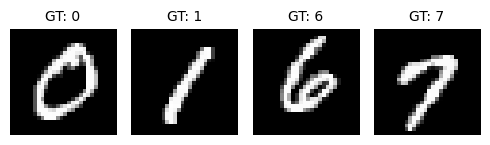

In [117]:
show_4_images(list(numbers.values()), list(numbers.keys()))

#### 1.1 train an auto encoder.
* Latent sapce is (Batch_size, channel, 1, 1).

In [118]:
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1), # 7*7
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1), # 3*3
            nn.ReLU(),
            nn.Conv2d(48, 1, 3, stride=1),# 1*1
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 48, 3, stride=1),  # 1->3
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1, output_padding=1),  # 3->7
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # 7->14
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1),  # 14->28
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [119]:
# Hyper Parameters
LR = 0.0009
IMAGE_SIZE = 28

model_cnn_AE = conv_autoencoder().to(device)

# set loss function
criterion = nn.MSELoss()
# set optimizer
optimizer = torch.optim.Adam(model_cnn_AE.parameters(), lr=LR, betas=(0.9, 0.999))
# Print the model summary
summary(model_cnn_AE, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
conv_autoencoder                         [1, 28, 28]               --
├─Sequential: 1-1                        [1, 1, 1]                 --
│    └─Conv2d: 2-1                       [12, 14, 14]              204
│    └─ReLU: 2-2                         [12, 14, 14]              --
│    └─Conv2d: 2-3                       [24, 7, 7]                4,632
│    └─ReLU: 2-4                         [24, 7, 7]                --
│    └─Conv2d: 2-5                       [48, 3, 3]                18,480
│    └─ReLU: 2-6                         [48, 3, 3]                --
│    └─Conv2d: 2-7                       [1, 1, 1]                 433
│    └─ReLU: 2-8                         [1, 1, 1]                 --
├─Sequential: 1-2                        [1, 28, 28]               --
│    └─ConvTranspose2d: 2-9              [48, 3, 3]                480
│    └─ReLU: 2-10                        [48, 3, 3]                --
│    

In [120]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch_2(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output = model(x)
        # see loss
        loss = criterion(output, x)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def test_2(test_dataloader, model, criterion):
    tot_loss = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(test_dataloader):
            _, losses = recreate_img(x, model, criterion)  # losses shape: (batch,)
            tot_loss.extend(losses.cpu().numpy().tolist())
    return tot_loss, np.mean(tot_loss)

def recreate_img(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)
        output = model(img_batch)
        loss_per_pixel = criterion(output, img_batch)  # shape: (batch, C, H, W)
        loss_per_image = loss_per_pixel.view(loss_per_pixel.size(0), -1).mean(dim=1)  # shape: (batch,)
    return output, loss_per_image  # return each image's loss



def plt_loss_accuracy_fig_2(Total_training_loss):
    # visualization the loss and accuracy
    plt.figure()
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    plt.title('Training & Validation loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Start training autoencoder...

In [121]:
# Start training and testing
best_loss = 100
NUM_EPOCHS = 500
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_2(small_dataloader, model_cnn_AE, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)
    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_0167_AE.pth'
            torch.save(model_cnn_AE.state_dict(), path)
            print("\t\33[33m==== Save model at epoch {:d} | best_loss = {:.4f} ====\33[0m".format(i+1, best_loss))

# save the final epoch's model
path = 'MNIST_0167_AE_final_epoch.pth'
torch.save(model_cnn_AE.state_dict(), path)
print("\t\33[33m==== Save FINAL model parameters in {:s} ====\33[0m".format(path))

100%|██████████| 4/4 [00:00<00:00, 189.76it/s]


Epoch[ 1/500] : train_loss = 1.0353
	==== Save model at epoch 1 | best_loss = 1.0353 ====


100%|██████████| 4/4 [00:00<00:00, 166.83it/s]


Epoch[ 2/500] : train_loss = 1.0099
	==== Save model at epoch 2 | best_loss = 1.0099 ====


100%|██████████| 4/4 [00:00<00:00, 121.19it/s]


Epoch[ 3/500] : train_loss = 0.9789
	==== Save model at epoch 3 | best_loss = 0.9789 ====


100%|██████████| 4/4 [00:00<00:00, 172.73it/s]


Epoch[ 4/500] : train_loss = 0.9281
	==== Save model at epoch 4 | best_loss = 0.9281 ====


100%|██████████| 4/4 [00:00<00:00, 170.72it/s]


Epoch[ 5/500] : train_loss = 0.7946
	==== Save model at epoch 5 | best_loss = 0.7946 ====


100%|██████████| 4/4 [00:00<00:00, 202.33it/s]


Epoch[ 6/500] : train_loss = 0.6241
	==== Save model at epoch 6 | best_loss = 0.6241 ====


100%|██████████| 4/4 [00:00<00:00, 193.01it/s]


Epoch[ 7/500] : train_loss = 0.5172
	==== Save model at epoch 7 | best_loss = 0.5172 ====


100%|██████████| 4/4 [00:00<00:00, 194.31it/s]


Epoch[ 8/500] : train_loss = 0.4617
	==== Save model at epoch 8 | best_loss = 0.4617 ====


100%|██████████| 4/4 [00:00<00:00, 179.39it/s]


Epoch[ 9/500] : train_loss = 0.4363
	==== Save model at epoch 9 | best_loss = 0.4363 ====


100%|██████████| 4/4 [00:00<00:00, 179.27it/s]


Epoch[10/500] : train_loss = 0.4271
	==== Save model at epoch 10 | best_loss = 0.4271 ====


100%|██████████| 4/4 [00:00<00:00, 225.77it/s]


Epoch[11/500] : train_loss = 0.4245
	==== Save model at epoch 11 | best_loss = 0.4245 ====


100%|██████████| 4/4 [00:00<00:00, 237.51it/s]


Epoch[12/500] : train_loss = 0.4232
	==== Save model at epoch 12 | best_loss = 0.4232 ====


100%|██████████| 4/4 [00:00<00:00, 224.92it/s]


Epoch[13/500] : train_loss = 0.4256


100%|██████████| 4/4 [00:00<00:00, 228.94it/s]


Epoch[14/500] : train_loss = 0.4269


100%|██████████| 4/4 [00:00<00:00, 218.60it/s]


Epoch[15/500] : train_loss = 0.4273


100%|██████████| 4/4 [00:00<00:00, 229.76it/s]


Epoch[16/500] : train_loss = 0.4262


100%|██████████| 4/4 [00:00<00:00, 260.53it/s]


Epoch[17/500] : train_loss = 0.4253


100%|██████████| 4/4 [00:00<00:00, 228.92it/s]


Epoch[18/500] : train_loss = 0.4248


100%|██████████| 4/4 [00:00<00:00, 227.28it/s]


Epoch[19/500] : train_loss = 0.4241


100%|██████████| 4/4 [00:00<00:00, 230.32it/s]


Epoch[20/500] : train_loss = 0.4245


100%|██████████| 4/4 [00:00<00:00, 211.49it/s]


Epoch[21/500] : train_loss = 0.4243


100%|██████████| 4/4 [00:00<00:00, 204.28it/s]


Epoch[22/500] : train_loss = 0.4230
	==== Save model at epoch 22 | best_loss = 0.4230 ====


100%|██████████| 4/4 [00:00<00:00, 262.31it/s]


Epoch[23/500] : train_loss = 0.4243


100%|██████████| 4/4 [00:00<00:00, 254.81it/s]


Epoch[24/500] : train_loss = 0.4245


100%|██████████| 4/4 [00:00<00:00, 218.36it/s]


Epoch[25/500] : train_loss = 0.4239


100%|██████████| 4/4 [00:00<00:00, 195.16it/s]


Epoch[26/500] : train_loss = 0.4235


100%|██████████| 4/4 [00:00<00:00, 228.83it/s]


Epoch[27/500] : train_loss = 0.4225
	==== Save model at epoch 27 | best_loss = 0.4225 ====


100%|██████████| 4/4 [00:00<00:00, 240.59it/s]


Epoch[28/500] : train_loss = 0.4209
	==== Save model at epoch 28 | best_loss = 0.4209 ====


100%|██████████| 4/4 [00:00<00:00, 196.07it/s]


Epoch[29/500] : train_loss = 0.4206
	==== Save model at epoch 29 | best_loss = 0.4206 ====


100%|██████████| 4/4 [00:00<00:00, 231.20it/s]


Epoch[30/500] : train_loss = 0.4195
	==== Save model at epoch 30 | best_loss = 0.4195 ====


100%|██████████| 4/4 [00:00<00:00, 228.56it/s]


Epoch[31/500] : train_loss = 0.4202


100%|██████████| 4/4 [00:00<00:00, 243.14it/s]


Epoch[32/500] : train_loss = 0.4197


100%|██████████| 4/4 [00:00<00:00, 214.53it/s]


Epoch[33/500] : train_loss = 0.4190
	==== Save model at epoch 33 | best_loss = 0.4190 ====


100%|██████████| 4/4 [00:00<00:00, 222.72it/s]


Epoch[34/500] : train_loss = 0.4199


100%|██████████| 4/4 [00:00<00:00, 212.66it/s]


Epoch[35/500] : train_loss = 0.4214


100%|██████████| 4/4 [00:00<00:00, 228.63it/s]


Epoch[36/500] : train_loss = 0.4199


100%|██████████| 4/4 [00:00<00:00, 237.70it/s]


Epoch[37/500] : train_loss = 0.4230


100%|██████████| 4/4 [00:00<00:00, 226.29it/s]


Epoch[38/500] : train_loss = 0.4182
	==== Save model at epoch 38 | best_loss = 0.4182 ====


100%|██████████| 4/4 [00:00<00:00, 210.62it/s]


Epoch[39/500] : train_loss = 0.4198


100%|██████████| 4/4 [00:00<00:00, 209.99it/s]


Epoch[40/500] : train_loss = 0.4187


100%|██████████| 4/4 [00:00<00:00, 222.74it/s]


Epoch[41/500] : train_loss = 0.4194


100%|██████████| 4/4 [00:00<00:00, 220.29it/s]


Epoch[42/500] : train_loss = 0.4178
	==== Save model at epoch 42 | best_loss = 0.4178 ====


100%|██████████| 4/4 [00:00<00:00, 229.67it/s]


Epoch[43/500] : train_loss = 0.4185


100%|██████████| 4/4 [00:00<00:00, 206.33it/s]


Epoch[44/500] : train_loss = 0.4174
	==== Save model at epoch 44 | best_loss = 0.4174 ====


100%|██████████| 4/4 [00:00<00:00, 182.45it/s]


Epoch[45/500] : train_loss = 0.4174
	==== Save model at epoch 45 | best_loss = 0.4174 ====


100%|██████████| 4/4 [00:00<00:00, 213.61it/s]


Epoch[46/500] : train_loss = 0.4174


100%|██████████| 4/4 [00:00<00:00, 236.04it/s]


Epoch[47/500] : train_loss = 0.4175


100%|██████████| 4/4 [00:00<00:00, 188.99it/s]


Epoch[48/500] : train_loss = 0.4176


100%|██████████| 4/4 [00:00<00:00, 198.42it/s]


Epoch[49/500] : train_loss = 0.4180


100%|██████████| 4/4 [00:00<00:00, 191.77it/s]


Epoch[50/500] : train_loss = 0.4189


100%|██████████| 4/4 [00:00<00:00, 176.26it/s]


Epoch[51/500] : train_loss = 0.4179


100%|██████████| 4/4 [00:00<00:00, 182.42it/s]


Epoch[52/500] : train_loss = 0.4179


100%|██████████| 4/4 [00:00<00:00, 176.52it/s]


Epoch[53/500] : train_loss = 0.4171
	==== Save model at epoch 53 | best_loss = 0.4171 ====


100%|██████████| 4/4 [00:00<00:00, 189.13it/s]


Epoch[54/500] : train_loss = 0.4171


100%|██████████| 4/4 [00:00<00:00, 235.44it/s]


Epoch[55/500] : train_loss = 0.4170
	==== Save model at epoch 55 | best_loss = 0.4170 ====


100%|██████████| 4/4 [00:00<00:00, 215.58it/s]


Epoch[56/500] : train_loss = 0.4166
	==== Save model at epoch 56 | best_loss = 0.4166 ====


100%|██████████| 4/4 [00:00<00:00, 223.85it/s]


Epoch[57/500] : train_loss = 0.4174


100%|██████████| 4/4 [00:00<00:00, 204.42it/s]


Epoch[58/500] : train_loss = 0.4172


100%|██████████| 4/4 [00:00<00:00, 223.27it/s]


Epoch[59/500] : train_loss = 0.4166


100%|██████████| 4/4 [00:00<00:00, 239.40it/s]


Epoch[60/500] : train_loss = 0.4160
	==== Save model at epoch 60 | best_loss = 0.4160 ====


100%|██████████| 4/4 [00:00<00:00, 206.18it/s]


Epoch[61/500] : train_loss = 0.4147
	==== Save model at epoch 61 | best_loss = 0.4147 ====


100%|██████████| 4/4 [00:00<00:00, 216.88it/s]


Epoch[62/500] : train_loss = 0.4137
	==== Save model at epoch 62 | best_loss = 0.4137 ====


100%|██████████| 4/4 [00:00<00:00, 201.24it/s]


Epoch[63/500] : train_loss = 0.4128
	==== Save model at epoch 63 | best_loss = 0.4128 ====


100%|██████████| 4/4 [00:00<00:00, 222.07it/s]


Epoch[64/500] : train_loss = 0.4123
	==== Save model at epoch 64 | best_loss = 0.4123 ====


100%|██████████| 4/4 [00:00<00:00, 228.01it/s]


Epoch[65/500] : train_loss = 0.4110
	==== Save model at epoch 65 | best_loss = 0.4110 ====


100%|██████████| 4/4 [00:00<00:00, 240.65it/s]


Epoch[66/500] : train_loss = 0.4099
	==== Save model at epoch 66 | best_loss = 0.4099 ====


100%|██████████| 4/4 [00:00<00:00, 241.41it/s]


Epoch[67/500] : train_loss = 0.4086
	==== Save model at epoch 67 | best_loss = 0.4086 ====


100%|██████████| 4/4 [00:00<00:00, 245.63it/s]


Epoch[68/500] : train_loss = 0.4066
	==== Save model at epoch 68 | best_loss = 0.4066 ====


100%|██████████| 4/4 [00:00<00:00, 194.03it/s]


Epoch[69/500] : train_loss = 0.4077


100%|██████████| 4/4 [00:00<00:00, 209.62it/s]


Epoch[70/500] : train_loss = 0.4070


100%|██████████| 4/4 [00:00<00:00, 229.10it/s]


Epoch[71/500] : train_loss = 0.4066
	==== Save model at epoch 71 | best_loss = 0.4066 ====


100%|██████████| 4/4 [00:00<00:00, 202.48it/s]


Epoch[72/500] : train_loss = 0.4069


100%|██████████| 4/4 [00:00<00:00, 229.38it/s]


Epoch[73/500] : train_loss = 0.4060
	==== Save model at epoch 73 | best_loss = 0.4060 ====


100%|██████████| 4/4 [00:00<00:00, 175.30it/s]


Epoch[74/500] : train_loss = 0.4052
	==== Save model at epoch 74 | best_loss = 0.4052 ====


100%|██████████| 4/4 [00:00<00:00, 230.44it/s]


Epoch[75/500] : train_loss = 0.4048
	==== Save model at epoch 75 | best_loss = 0.4048 ====


100%|██████████| 4/4 [00:00<00:00, 229.53it/s]


Epoch[76/500] : train_loss = 0.4035
	==== Save model at epoch 76 | best_loss = 0.4035 ====


100%|██████████| 4/4 [00:00<00:00, 248.64it/s]


Epoch[77/500] : train_loss = 0.4034
	==== Save model at epoch 77 | best_loss = 0.4034 ====


100%|██████████| 4/4 [00:00<00:00, 222.31it/s]


Epoch[78/500] : train_loss = 0.4023
	==== Save model at epoch 78 | best_loss = 0.4023 ====


100%|██████████| 4/4 [00:00<00:00, 192.98it/s]


Epoch[79/500] : train_loss = 0.3987
	==== Save model at epoch 79 | best_loss = 0.3987 ====


100%|██████████| 4/4 [00:00<00:00, 218.14it/s]


Epoch[80/500] : train_loss = 0.3855
	==== Save model at epoch 80 | best_loss = 0.3855 ====


100%|██████████| 4/4 [00:00<00:00, 211.46it/s]


Epoch[81/500] : train_loss = 0.3601
	==== Save model at epoch 81 | best_loss = 0.3601 ====


100%|██████████| 4/4 [00:00<00:00, 189.58it/s]


Epoch[82/500] : train_loss = 0.3216
	==== Save model at epoch 82 | best_loss = 0.3216 ====


100%|██████████| 4/4 [00:00<00:00, 120.30it/s]


Epoch[83/500] : train_loss = 0.2871
	==== Save model at epoch 83 | best_loss = 0.2871 ====


100%|██████████| 4/4 [00:00<00:00, 159.94it/s]


Epoch[84/500] : train_loss = 0.2642
	==== Save model at epoch 84 | best_loss = 0.2642 ====


100%|██████████| 4/4 [00:00<00:00, 169.64it/s]


Epoch[85/500] : train_loss = 0.2476
	==== Save model at epoch 85 | best_loss = 0.2476 ====


100%|██████████| 4/4 [00:00<00:00, 224.16it/s]


Epoch[86/500] : train_loss = 0.2386
	==== Save model at epoch 86 | best_loss = 0.2386 ====


100%|██████████| 4/4 [00:00<00:00, 222.51it/s]


Epoch[87/500] : train_loss = 0.2342
	==== Save model at epoch 87 | best_loss = 0.2342 ====


100%|██████████| 4/4 [00:00<00:00, 230.78it/s]


Epoch[88/500] : train_loss = 0.2302
	==== Save model at epoch 88 | best_loss = 0.2302 ====


100%|██████████| 4/4 [00:00<00:00, 219.85it/s]


Epoch[89/500] : train_loss = 0.2254
	==== Save model at epoch 89 | best_loss = 0.2254 ====


100%|██████████| 4/4 [00:00<00:00, 252.79it/s]


Epoch[90/500] : train_loss = 0.2197
	==== Save model at epoch 90 | best_loss = 0.2197 ====


100%|██████████| 4/4 [00:00<00:00, 226.25it/s]


Epoch[91/500] : train_loss = 0.2179
	==== Save model at epoch 91 | best_loss = 0.2179 ====


100%|██████████| 4/4 [00:00<00:00, 239.83it/s]


Epoch[92/500] : train_loss = 0.2145
	==== Save model at epoch 92 | best_loss = 0.2145 ====


100%|██████████| 4/4 [00:00<00:00, 178.36it/s]


Epoch[93/500] : train_loss = 0.2110
	==== Save model at epoch 93 | best_loss = 0.2110 ====


100%|██████████| 4/4 [00:00<00:00, 207.69it/s]


Epoch[94/500] : train_loss = 0.2114


100%|██████████| 4/4 [00:00<00:00, 215.03it/s]


Epoch[95/500] : train_loss = 0.2103
	==== Save model at epoch 95 | best_loss = 0.2103 ====


100%|██████████| 4/4 [00:00<00:00, 229.99it/s]


Epoch[96/500] : train_loss = 0.2074
	==== Save model at epoch 96 | best_loss = 0.2074 ====


100%|██████████| 4/4 [00:00<00:00, 235.57it/s]


Epoch[97/500] : train_loss = 0.2053
	==== Save model at epoch 97 | best_loss = 0.2053 ====


100%|██████████| 4/4 [00:00<00:00, 193.87it/s]


Epoch[98/500] : train_loss = 0.2049
	==== Save model at epoch 98 | best_loss = 0.2049 ====


100%|██████████| 4/4 [00:00<00:00, 212.39it/s]


Epoch[99/500] : train_loss = 0.2046
	==== Save model at epoch 99 | best_loss = 0.2046 ====


100%|██████████| 4/4 [00:00<00:00, 208.31it/s]


Epoch[100/500] : train_loss = 0.2032
	==== Save model at epoch 100 | best_loss = 0.2032 ====


100%|██████████| 4/4 [00:00<00:00, 248.78it/s]


Epoch[101/500] : train_loss = 0.2018
	==== Save model at epoch 101 | best_loss = 0.2018 ====


100%|██████████| 4/4 [00:00<00:00, 183.06it/s]


Epoch[102/500] : train_loss = 0.2015
	==== Save model at epoch 102 | best_loss = 0.2015 ====


100%|██████████| 4/4 [00:00<00:00, 245.13it/s]


Epoch[103/500] : train_loss = 0.2006
	==== Save model at epoch 103 | best_loss = 0.2006 ====


100%|██████████| 4/4 [00:00<00:00, 248.01it/s]


Epoch[104/500] : train_loss = 0.2006
	==== Save model at epoch 104 | best_loss = 0.2006 ====


100%|██████████| 4/4 [00:00<00:00, 234.72it/s]


Epoch[105/500] : train_loss = 0.1996
	==== Save model at epoch 105 | best_loss = 0.1996 ====


100%|██████████| 4/4 [00:00<00:00, 222.41it/s]


Epoch[106/500] : train_loss = 0.2008


100%|██████████| 4/4 [00:00<00:00, 251.32it/s]


Epoch[107/500] : train_loss = 0.1995
	==== Save model at epoch 107 | best_loss = 0.1995 ====


100%|██████████| 4/4 [00:00<00:00, 226.34it/s]


Epoch[108/500] : train_loss = 0.1994
	==== Save model at epoch 108 | best_loss = 0.1994 ====


100%|██████████| 4/4 [00:00<00:00, 241.70it/s]


Epoch[109/500] : train_loss = 0.1989
	==== Save model at epoch 109 | best_loss = 0.1989 ====


100%|██████████| 4/4 [00:00<00:00, 210.87it/s]


Epoch[110/500] : train_loss = 0.1985
	==== Save model at epoch 110 | best_loss = 0.1985 ====


100%|██████████| 4/4 [00:00<00:00, 232.24it/s]


Epoch[111/500] : train_loss = 0.1979
	==== Save model at epoch 111 | best_loss = 0.1979 ====


100%|██████████| 4/4 [00:00<00:00, 230.60it/s]


Epoch[112/500] : train_loss = 0.1979


100%|██████████| 4/4 [00:00<00:00, 250.32it/s]


Epoch[113/500] : train_loss = 0.1970
	==== Save model at epoch 113 | best_loss = 0.1970 ====


100%|██████████| 4/4 [00:00<00:00, 253.14it/s]


Epoch[114/500] : train_loss = 0.1970
	==== Save model at epoch 114 | best_loss = 0.1970 ====


100%|██████████| 4/4 [00:00<00:00, 220.25it/s]


Epoch[115/500] : train_loss = 0.1983


100%|██████████| 4/4 [00:00<00:00, 241.19it/s]


Epoch[116/500] : train_loss = 0.1966
	==== Save model at epoch 116 | best_loss = 0.1966 ====


100%|██████████| 4/4 [00:00<00:00, 222.13it/s]


Epoch[117/500] : train_loss = 0.1962
	==== Save model at epoch 117 | best_loss = 0.1962 ====


100%|██████████| 4/4 [00:00<00:00, 198.55it/s]


Epoch[118/500] : train_loss = 0.1960
	==== Save model at epoch 118 | best_loss = 0.1960 ====


100%|██████████| 4/4 [00:00<00:00, 233.02it/s]


Epoch[119/500] : train_loss = 0.1953
	==== Save model at epoch 119 | best_loss = 0.1953 ====


100%|██████████| 4/4 [00:00<00:00, 200.26it/s]


Epoch[120/500] : train_loss = 0.1952
	==== Save model at epoch 120 | best_loss = 0.1952 ====


100%|██████████| 4/4 [00:00<00:00, 251.11it/s]


Epoch[121/500] : train_loss = 0.1945
	==== Save model at epoch 121 | best_loss = 0.1945 ====


100%|██████████| 4/4 [00:00<00:00, 254.74it/s]


Epoch[122/500] : train_loss = 0.1941
	==== Save model at epoch 122 | best_loss = 0.1941 ====


100%|██████████| 4/4 [00:00<00:00, 228.77it/s]


Epoch[123/500] : train_loss = 0.1948


100%|██████████| 4/4 [00:00<00:00, 224.47it/s]


Epoch[124/500] : train_loss = 0.1941


100%|██████████| 4/4 [00:00<00:00, 218.44it/s]


Epoch[125/500] : train_loss = 0.1943


100%|██████████| 4/4 [00:00<00:00, 188.82it/s]


Epoch[126/500] : train_loss = 0.1934
	==== Save model at epoch 126 | best_loss = 0.1934 ====


100%|██████████| 4/4 [00:00<00:00, 186.51it/s]


Epoch[127/500] : train_loss = 0.1925
	==== Save model at epoch 127 | best_loss = 0.1925 ====


100%|██████████| 4/4 [00:00<00:00, 213.23it/s]


Epoch[128/500] : train_loss = 0.1925
	==== Save model at epoch 128 | best_loss = 0.1925 ====


100%|██████████| 4/4 [00:00<00:00, 207.41it/s]


Epoch[129/500] : train_loss = 0.1921
	==== Save model at epoch 129 | best_loss = 0.1921 ====


100%|██████████| 4/4 [00:00<00:00, 221.06it/s]


Epoch[130/500] : train_loss = 0.1920
	==== Save model at epoch 130 | best_loss = 0.1920 ====


100%|██████████| 4/4 [00:00<00:00, 221.39it/s]


Epoch[131/500] : train_loss = 0.1915
	==== Save model at epoch 131 | best_loss = 0.1915 ====


100%|██████████| 4/4 [00:00<00:00, 226.55it/s]


Epoch[132/500] : train_loss = 0.1906
	==== Save model at epoch 132 | best_loss = 0.1906 ====


100%|██████████| 4/4 [00:00<00:00, 223.96it/s]


Epoch[133/500] : train_loss = 0.1915


100%|██████████| 4/4 [00:00<00:00, 231.05it/s]


Epoch[134/500] : train_loss = 0.1902
	==== Save model at epoch 134 | best_loss = 0.1902 ====


100%|██████████| 4/4 [00:00<00:00, 249.22it/s]


Epoch[135/500] : train_loss = 0.1897
	==== Save model at epoch 135 | best_loss = 0.1897 ====


100%|██████████| 4/4 [00:00<00:00, 201.62it/s]


Epoch[136/500] : train_loss = 0.1900


100%|██████████| 4/4 [00:00<00:00, 214.86it/s]


Epoch[137/500] : train_loss = 0.1888
	==== Save model at epoch 137 | best_loss = 0.1888 ====


100%|██████████| 4/4 [00:00<00:00, 214.36it/s]


Epoch[138/500] : train_loss = 0.1884
	==== Save model at epoch 138 | best_loss = 0.1884 ====


100%|██████████| 4/4 [00:00<00:00, 255.36it/s]


Epoch[139/500] : train_loss = 0.1886


100%|██████████| 4/4 [00:00<00:00, 228.78it/s]


Epoch[140/500] : train_loss = 0.1876
	==== Save model at epoch 140 | best_loss = 0.1876 ====


100%|██████████| 4/4 [00:00<00:00, 198.64it/s]


Epoch[141/500] : train_loss = 0.1875
	==== Save model at epoch 141 | best_loss = 0.1875 ====


100%|██████████| 4/4 [00:00<00:00, 226.22it/s]


Epoch[142/500] : train_loss = 0.1880


100%|██████████| 4/4 [00:00<00:00, 271.38it/s]


Epoch[143/500] : train_loss = 0.1865
	==== Save model at epoch 143 | best_loss = 0.1865 ====


100%|██████████| 4/4 [00:00<00:00, 219.29it/s]


Epoch[144/500] : train_loss = 0.1861
	==== Save model at epoch 144 | best_loss = 0.1861 ====


100%|██████████| 4/4 [00:00<00:00, 273.44it/s]


Epoch[145/500] : train_loss = 0.1867


100%|██████████| 4/4 [00:00<00:00, 228.85it/s]


Epoch[146/500] : train_loss = 0.1853
	==== Save model at epoch 146 | best_loss = 0.1853 ====


100%|██████████| 4/4 [00:00<00:00, 217.99it/s]


Epoch[147/500] : train_loss = 0.1842
	==== Save model at epoch 147 | best_loss = 0.1842 ====


100%|██████████| 4/4 [00:00<00:00, 214.34it/s]


Epoch[148/500] : train_loss = 0.1846


100%|██████████| 4/4 [00:00<00:00, 223.66it/s]


Epoch[149/500] : train_loss = 0.1833
	==== Save model at epoch 149 | best_loss = 0.1833 ====


100%|██████████| 4/4 [00:00<00:00, 147.46it/s]


Epoch[150/500] : train_loss = 0.1828
	==== Save model at epoch 150 | best_loss = 0.1828 ====


100%|██████████| 4/4 [00:00<00:00, 131.38it/s]


Epoch[151/500] : train_loss = 0.1828


100%|██████████| 4/4 [00:00<00:00, 172.58it/s]


Epoch[152/500] : train_loss = 0.1831


100%|██████████| 4/4 [00:00<00:00, 213.57it/s]


Epoch[153/500] : train_loss = 0.1823
	==== Save model at epoch 153 | best_loss = 0.1823 ====


100%|██████████| 4/4 [00:00<00:00, 226.58it/s]


Epoch[154/500] : train_loss = 0.1827


100%|██████████| 4/4 [00:00<00:00, 227.58it/s]


Epoch[155/500] : train_loss = 0.1810
	==== Save model at epoch 155 | best_loss = 0.1810 ====


100%|██████████| 4/4 [00:00<00:00, 223.72it/s]


Epoch[156/500] : train_loss = 0.1796
	==== Save model at epoch 156 | best_loss = 0.1796 ====


100%|██████████| 4/4 [00:00<00:00, 242.14it/s]


Epoch[157/500] : train_loss = 0.1794
	==== Save model at epoch 157 | best_loss = 0.1794 ====


100%|██████████| 4/4 [00:00<00:00, 228.41it/s]


Epoch[158/500] : train_loss = 0.1801


100%|██████████| 4/4 [00:00<00:00, 259.48it/s]


Epoch[159/500] : train_loss = 0.1778
	==== Save model at epoch 159 | best_loss = 0.1778 ====


100%|██████████| 4/4 [00:00<00:00, 206.97it/s]


Epoch[160/500] : train_loss = 0.1840


100%|██████████| 4/4 [00:00<00:00, 220.80it/s]


Epoch[161/500] : train_loss = 0.1776
	==== Save model at epoch 161 | best_loss = 0.1776 ====


100%|██████████| 4/4 [00:00<00:00, 212.49it/s]


Epoch[162/500] : train_loss = 0.1819


100%|██████████| 4/4 [00:00<00:00, 236.32it/s]


Epoch[163/500] : train_loss = 0.1808


100%|██████████| 4/4 [00:00<00:00, 225.78it/s]


Epoch[164/500] : train_loss = 0.1774
	==== Save model at epoch 164 | best_loss = 0.1774 ====


100%|██████████| 4/4 [00:00<00:00, 234.33it/s]


Epoch[165/500] : train_loss = 0.1758
	==== Save model at epoch 165 | best_loss = 0.1758 ====


100%|██████████| 4/4 [00:00<00:00, 242.79it/s]


Epoch[166/500] : train_loss = 0.1747
	==== Save model at epoch 166 | best_loss = 0.1747 ====


100%|██████████| 4/4 [00:00<00:00, 258.35it/s]


Epoch[167/500] : train_loss = 0.1772


100%|██████████| 4/4 [00:00<00:00, 223.19it/s]


Epoch[168/500] : train_loss = 0.1746
	==== Save model at epoch 168 | best_loss = 0.1746 ====


100%|██████████| 4/4 [00:00<00:00, 259.84it/s]


Epoch[169/500] : train_loss = 0.1770


100%|██████████| 4/4 [00:00<00:00, 215.81it/s]


Epoch[170/500] : train_loss = 0.1800


100%|██████████| 4/4 [00:00<00:00, 217.51it/s]


Epoch[171/500] : train_loss = 0.1731
	==== Save model at epoch 171 | best_loss = 0.1731 ====


100%|██████████| 4/4 [00:00<00:00, 253.89it/s]


Epoch[172/500] : train_loss = 0.1743


100%|██████████| 4/4 [00:00<00:00, 212.30it/s]


Epoch[173/500] : train_loss = 0.1728
	==== Save model at epoch 173 | best_loss = 0.1728 ====


100%|██████████| 4/4 [00:00<00:00, 213.76it/s]


Epoch[174/500] : train_loss = 0.1725
	==== Save model at epoch 174 | best_loss = 0.1725 ====


100%|██████████| 4/4 [00:00<00:00, 244.96it/s]


Epoch[175/500] : train_loss = 0.1755


100%|██████████| 4/4 [00:00<00:00, 197.27it/s]


Epoch[176/500] : train_loss = 0.1858


100%|██████████| 4/4 [00:00<00:00, 244.64it/s]


Epoch[177/500] : train_loss = 0.1865


100%|██████████| 4/4 [00:00<00:00, 246.88it/s]


Epoch[178/500] : train_loss = 0.1778


100%|██████████| 4/4 [00:00<00:00, 229.07it/s]


Epoch[179/500] : train_loss = 0.1727


100%|██████████| 4/4 [00:00<00:00, 242.99it/s]


Epoch[180/500] : train_loss = 0.1752


100%|██████████| 4/4 [00:00<00:00, 236.43it/s]


Epoch[181/500] : train_loss = 0.1732


100%|██████████| 4/4 [00:00<00:00, 245.27it/s]


Epoch[182/500] : train_loss = 0.1723
	==== Save model at epoch 182 | best_loss = 0.1723 ====


100%|██████████| 4/4 [00:00<00:00, 229.47it/s]


Epoch[183/500] : train_loss = 0.1700
	==== Save model at epoch 183 | best_loss = 0.1700 ====


100%|██████████| 4/4 [00:00<00:00, 209.16it/s]


Epoch[184/500] : train_loss = 0.1691
	==== Save model at epoch 184 | best_loss = 0.1691 ====


100%|██████████| 4/4 [00:00<00:00, 232.49it/s]


Epoch[185/500] : train_loss = 0.1681
	==== Save model at epoch 185 | best_loss = 0.1681 ====


100%|██████████| 4/4 [00:00<00:00, 232.01it/s]


Epoch[186/500] : train_loss = 0.1667
	==== Save model at epoch 186 | best_loss = 0.1667 ====


100%|██████████| 4/4 [00:00<00:00, 204.80it/s]


Epoch[187/500] : train_loss = 0.1663
	==== Save model at epoch 187 | best_loss = 0.1663 ====


100%|██████████| 4/4 [00:00<00:00, 196.37it/s]


Epoch[188/500] : train_loss = 0.1651
	==== Save model at epoch 188 | best_loss = 0.1651 ====


100%|██████████| 4/4 [00:00<00:00, 196.85it/s]


Epoch[189/500] : train_loss = 0.1654


100%|██████████| 4/4 [00:00<00:00, 174.00it/s]


Epoch[190/500] : train_loss = 0.1642
	==== Save model at epoch 190 | best_loss = 0.1642 ====


100%|██████████| 4/4 [00:00<00:00, 187.62it/s]


Epoch[191/500] : train_loss = 0.1640
	==== Save model at epoch 191 | best_loss = 0.1640 ====


100%|██████████| 4/4 [00:00<00:00, 171.82it/s]


Epoch[192/500] : train_loss = 0.1637
	==== Save model at epoch 192 | best_loss = 0.1637 ====


100%|██████████| 4/4 [00:00<00:00, 197.80it/s]


Epoch[193/500] : train_loss = 0.1633
	==== Save model at epoch 193 | best_loss = 0.1633 ====


100%|██████████| 4/4 [00:00<00:00, 190.39it/s]


Epoch[194/500] : train_loss = 0.1639


100%|██████████| 4/4 [00:00<00:00, 220.00it/s]


Epoch[195/500] : train_loss = 0.1710


100%|██████████| 4/4 [00:00<00:00, 204.17it/s]


Epoch[196/500] : train_loss = 0.1712


100%|██████████| 4/4 [00:00<00:00, 218.32it/s]


Epoch[197/500] : train_loss = 0.1833


100%|██████████| 4/4 [00:00<00:00, 232.49it/s]


Epoch[198/500] : train_loss = 0.1747


100%|██████████| 4/4 [00:00<00:00, 233.67it/s]


Epoch[199/500] : train_loss = 0.1754


100%|██████████| 4/4 [00:00<00:00, 200.40it/s]


Epoch[200/500] : train_loss = 0.1747


100%|██████████| 4/4 [00:00<00:00, 211.32it/s]


Epoch[201/500] : train_loss = 0.1717


100%|██████████| 4/4 [00:00<00:00, 239.74it/s]


Epoch[202/500] : train_loss = 0.1715


100%|██████████| 4/4 [00:00<00:00, 237.42it/s]


Epoch[203/500] : train_loss = 0.1664


100%|██████████| 4/4 [00:00<00:00, 219.59it/s]


Epoch[204/500] : train_loss = 0.1649


100%|██████████| 4/4 [00:00<00:00, 230.96it/s]


Epoch[205/500] : train_loss = 0.1631
	==== Save model at epoch 205 | best_loss = 0.1631 ====


100%|██████████| 4/4 [00:00<00:00, 212.69it/s]


Epoch[206/500] : train_loss = 0.1626
	==== Save model at epoch 206 | best_loss = 0.1626 ====


100%|██████████| 4/4 [00:00<00:00, 212.53it/s]


Epoch[207/500] : train_loss = 0.1613
	==== Save model at epoch 207 | best_loss = 0.1613 ====


100%|██████████| 4/4 [00:00<00:00, 179.48it/s]


Epoch[208/500] : train_loss = 0.1600
	==== Save model at epoch 208 | best_loss = 0.1600 ====


100%|██████████| 4/4 [00:00<00:00, 125.69it/s]


Epoch[209/500] : train_loss = 0.1602


100%|██████████| 4/4 [00:00<00:00, 149.68it/s]


Epoch[210/500] : train_loss = 0.1595
	==== Save model at epoch 210 | best_loss = 0.1595 ====


100%|██████████| 4/4 [00:00<00:00, 232.89it/s]


Epoch[211/500] : train_loss = 0.1587
	==== Save model at epoch 211 | best_loss = 0.1587 ====


100%|██████████| 4/4 [00:00<00:00, 243.32it/s]


Epoch[212/500] : train_loss = 0.1575
	==== Save model at epoch 212 | best_loss = 0.1575 ====


100%|██████████| 4/4 [00:00<00:00, 239.97it/s]


Epoch[213/500] : train_loss = 0.1592


100%|██████████| 4/4 [00:00<00:00, 260.86it/s]


Epoch[214/500] : train_loss = 0.1562
	==== Save model at epoch 214 | best_loss = 0.1562 ====


100%|██████████| 4/4 [00:00<00:00, 220.13it/s]


Epoch[215/500] : train_loss = 0.1581


100%|██████████| 4/4 [00:00<00:00, 273.72it/s]


Epoch[216/500] : train_loss = 0.1570


100%|██████████| 4/4 [00:00<00:00, 220.92it/s]


Epoch[217/500] : train_loss = 0.1553
	==== Save model at epoch 217 | best_loss = 0.1553 ====


100%|██████████| 4/4 [00:00<00:00, 179.23it/s]


Epoch[218/500] : train_loss = 0.1545
	==== Save model at epoch 218 | best_loss = 0.1545 ====


100%|██████████| 4/4 [00:00<00:00, 192.91it/s]


Epoch[219/500] : train_loss = 0.1544
	==== Save model at epoch 219 | best_loss = 0.1544 ====


100%|██████████| 4/4 [00:00<00:00, 239.38it/s]


Epoch[220/500] : train_loss = 0.1545


100%|██████████| 4/4 [00:00<00:00, 199.72it/s]


Epoch[221/500] : train_loss = 0.1534
	==== Save model at epoch 221 | best_loss = 0.1534 ====


100%|██████████| 4/4 [00:00<00:00, 209.23it/s]


Epoch[222/500] : train_loss = 0.1573


100%|██████████| 4/4 [00:00<00:00, 263.36it/s]


Epoch[223/500] : train_loss = 0.1559


100%|██████████| 4/4 [00:00<00:00, 237.18it/s]


Epoch[224/500] : train_loss = 0.1577


100%|██████████| 4/4 [00:00<00:00, 187.49it/s]


Epoch[225/500] : train_loss = 0.1550


100%|██████████| 4/4 [00:00<00:00, 220.25it/s]


Epoch[226/500] : train_loss = 0.1552


100%|██████████| 4/4 [00:00<00:00, 211.81it/s]


Epoch[227/500] : train_loss = 0.1540


100%|██████████| 4/4 [00:00<00:00, 201.47it/s]


Epoch[228/500] : train_loss = 0.1547


100%|██████████| 4/4 [00:00<00:00, 254.15it/s]


Epoch[229/500] : train_loss = 0.1534
	==== Save model at epoch 229 | best_loss = 0.1534 ====


100%|██████████| 4/4 [00:00<00:00, 206.88it/s]


Epoch[230/500] : train_loss = 0.1572


100%|██████████| 4/4 [00:00<00:00, 194.02it/s]


Epoch[231/500] : train_loss = 0.1670


100%|██████████| 4/4 [00:00<00:00, 208.23it/s]


Epoch[232/500] : train_loss = 0.1617


100%|██████████| 4/4 [00:00<00:00, 246.04it/s]


Epoch[233/500] : train_loss = 0.1627


100%|██████████| 4/4 [00:00<00:00, 204.16it/s]


Epoch[234/500] : train_loss = 0.1616


100%|██████████| 4/4 [00:00<00:00, 226.59it/s]


Epoch[235/500] : train_loss = 0.1630


100%|██████████| 4/4 [00:00<00:00, 212.82it/s]


Epoch[236/500] : train_loss = 0.1550


100%|██████████| 4/4 [00:00<00:00, 235.80it/s]


Epoch[237/500] : train_loss = 0.1565


100%|██████████| 4/4 [00:00<00:00, 227.48it/s]


Epoch[238/500] : train_loss = 0.1582


100%|██████████| 4/4 [00:00<00:00, 251.07it/s]


Epoch[239/500] : train_loss = 0.1575


100%|██████████| 4/4 [00:00<00:00, 238.25it/s]


Epoch[240/500] : train_loss = 0.1533
	==== Save model at epoch 240 | best_loss = 0.1533 ====


100%|██████████| 4/4 [00:00<00:00, 226.07it/s]


Epoch[241/500] : train_loss = 0.1537


100%|██████████| 4/4 [00:00<00:00, 200.91it/s]


Epoch[242/500] : train_loss = 0.1514
	==== Save model at epoch 242 | best_loss = 0.1514 ====


100%|██████████| 4/4 [00:00<00:00, 243.55it/s]


Epoch[243/500] : train_loss = 0.1512
	==== Save model at epoch 243 | best_loss = 0.1512 ====


100%|██████████| 4/4 [00:00<00:00, 225.71it/s]


Epoch[244/500] : train_loss = 0.1502
	==== Save model at epoch 244 | best_loss = 0.1502 ====


100%|██████████| 4/4 [00:00<00:00, 233.51it/s]


Epoch[245/500] : train_loss = 0.1486
	==== Save model at epoch 245 | best_loss = 0.1486 ====


100%|██████████| 4/4 [00:00<00:00, 221.11it/s]


Epoch[246/500] : train_loss = 0.1485
	==== Save model at epoch 246 | best_loss = 0.1485 ====


100%|██████████| 4/4 [00:00<00:00, 214.55it/s]


Epoch[247/500] : train_loss = 0.1469
	==== Save model at epoch 247 | best_loss = 0.1469 ====


100%|██████████| 4/4 [00:00<00:00, 270.07it/s]


Epoch[248/500] : train_loss = 0.1474


100%|██████████| 4/4 [00:00<00:00, 221.70it/s]


Epoch[249/500] : train_loss = 0.1477


100%|██████████| 4/4 [00:00<00:00, 245.44it/s]


Epoch[250/500] : train_loss = 0.1499


100%|██████████| 4/4 [00:00<00:00, 212.01it/s]


Epoch[251/500] : train_loss = 0.1575


100%|██████████| 4/4 [00:00<00:00, 215.05it/s]


Epoch[252/500] : train_loss = 0.1607


100%|██████████| 4/4 [00:00<00:00, 255.49it/s]


Epoch[253/500] : train_loss = 0.1503


100%|██████████| 4/4 [00:00<00:00, 201.56it/s]


Epoch[254/500] : train_loss = 0.1482


100%|██████████| 4/4 [00:00<00:00, 201.02it/s]


Epoch[255/500] : train_loss = 0.1494


100%|██████████| 4/4 [00:00<00:00, 207.30it/s]


Epoch[256/500] : train_loss = 0.1465
	==== Save model at epoch 256 | best_loss = 0.1465 ====


100%|██████████| 4/4 [00:00<00:00, 203.88it/s]


Epoch[257/500] : train_loss = 0.1464
	==== Save model at epoch 257 | best_loss = 0.1464 ====


100%|██████████| 4/4 [00:00<00:00, 197.11it/s]


Epoch[258/500] : train_loss = 0.1444
	==== Save model at epoch 258 | best_loss = 0.1444 ====


100%|██████████| 4/4 [00:00<00:00, 203.41it/s]


Epoch[259/500] : train_loss = 0.1458


100%|██████████| 4/4 [00:00<00:00, 226.46it/s]


Epoch[260/500] : train_loss = 0.1428
	==== Save model at epoch 260 | best_loss = 0.1428 ====


100%|██████████| 4/4 [00:00<00:00, 120.89it/s]


Epoch[261/500] : train_loss = 0.1419
	==== Save model at epoch 261 | best_loss = 0.1419 ====


100%|██████████| 4/4 [00:00<00:00, 127.06it/s]


Epoch[262/500] : train_loss = 0.1411
	==== Save model at epoch 262 | best_loss = 0.1411 ====


100%|██████████| 4/4 [00:00<00:00, 160.14it/s]


Epoch[263/500] : train_loss = 0.1438


100%|██████████| 4/4 [00:00<00:00, 230.94it/s]


Epoch[264/500] : train_loss = 0.1473


100%|██████████| 4/4 [00:00<00:00, 224.42it/s]


Epoch[265/500] : train_loss = 0.1405
	==== Save model at epoch 265 | best_loss = 0.1405 ====


100%|██████████| 4/4 [00:00<00:00, 248.30it/s]


Epoch[266/500] : train_loss = 0.1459


100%|██████████| 4/4 [00:00<00:00, 200.04it/s]


Epoch[267/500] : train_loss = 0.1401
	==== Save model at epoch 267 | best_loss = 0.1401 ====


100%|██████████| 4/4 [00:00<00:00, 235.20it/s]


Epoch[268/500] : train_loss = 0.1457


100%|██████████| 4/4 [00:00<00:00, 220.21it/s]


Epoch[269/500] : train_loss = 0.1442


100%|██████████| 4/4 [00:00<00:00, 204.66it/s]


Epoch[270/500] : train_loss = 0.1427


100%|██████████| 4/4 [00:00<00:00, 237.48it/s]


Epoch[271/500] : train_loss = 0.1425


100%|██████████| 4/4 [00:00<00:00, 195.94it/s]


Epoch[272/500] : train_loss = 0.1424


100%|██████████| 4/4 [00:00<00:00, 211.94it/s]


Epoch[273/500] : train_loss = 0.1452


100%|██████████| 4/4 [00:00<00:00, 194.58it/s]


Epoch[274/500] : train_loss = 0.1404


100%|██████████| 4/4 [00:00<00:00, 187.32it/s]


Epoch[275/500] : train_loss = 0.1410


100%|██████████| 4/4 [00:00<00:00, 180.69it/s]


Epoch[276/500] : train_loss = 0.1448


100%|██████████| 4/4 [00:00<00:00, 245.74it/s]


Epoch[277/500] : train_loss = 0.1443


100%|██████████| 4/4 [00:00<00:00, 193.15it/s]


Epoch[278/500] : train_loss = 0.1589


100%|██████████| 4/4 [00:00<00:00, 253.13it/s]


Epoch[279/500] : train_loss = 0.1515


100%|██████████| 4/4 [00:00<00:00, 208.48it/s]


Epoch[280/500] : train_loss = 0.1412


100%|██████████| 4/4 [00:00<00:00, 243.51it/s]


Epoch[281/500] : train_loss = 0.1417


100%|██████████| 4/4 [00:00<00:00, 213.67it/s]


Epoch[282/500] : train_loss = 0.1393
	==== Save model at epoch 282 | best_loss = 0.1393 ====


100%|██████████| 4/4 [00:00<00:00, 209.47it/s]


Epoch[283/500] : train_loss = 0.1375
	==== Save model at epoch 283 | best_loss = 0.1375 ====


100%|██████████| 4/4 [00:00<00:00, 216.07it/s]


Epoch[284/500] : train_loss = 0.1369
	==== Save model at epoch 284 | best_loss = 0.1369 ====


100%|██████████| 4/4 [00:00<00:00, 207.69it/s]


Epoch[285/500] : train_loss = 0.1338
	==== Save model at epoch 285 | best_loss = 0.1338 ====


100%|██████████| 4/4 [00:00<00:00, 209.94it/s]


Epoch[286/500] : train_loss = 0.1339


100%|██████████| 4/4 [00:00<00:00, 187.78it/s]


Epoch[287/500] : train_loss = 0.1367


100%|██████████| 4/4 [00:00<00:00, 196.35it/s]


Epoch[288/500] : train_loss = 0.1324
	==== Save model at epoch 288 | best_loss = 0.1324 ====


100%|██████████| 4/4 [00:00<00:00, 183.24it/s]


Epoch[289/500] : train_loss = 0.1338


100%|██████████| 4/4 [00:00<00:00, 161.02it/s]


Epoch[290/500] : train_loss = 0.1306
	==== Save model at epoch 290 | best_loss = 0.1306 ====


100%|██████████| 4/4 [00:00<00:00, 153.95it/s]


Epoch[291/500] : train_loss = 0.1325


100%|██████████| 4/4 [00:00<00:00, 194.52it/s]


Epoch[292/500] : train_loss = 0.1307


100%|██████████| 4/4 [00:00<00:00, 133.41it/s]


Epoch[293/500] : train_loss = 0.1306


100%|██████████| 4/4 [00:00<00:00, 161.47it/s]


Epoch[294/500] : train_loss = 0.1279
	==== Save model at epoch 294 | best_loss = 0.1279 ====


100%|██████████| 4/4 [00:00<00:00, 114.36it/s]


Epoch[295/500] : train_loss = 0.1269
	==== Save model at epoch 295 | best_loss = 0.1269 ====


100%|██████████| 4/4 [00:00<00:00, 139.50it/s]


Epoch[296/500] : train_loss = 0.1256
	==== Save model at epoch 296 | best_loss = 0.1256 ====


100%|██████████| 4/4 [00:00<00:00, 161.88it/s]


Epoch[297/500] : train_loss = 0.1243
	==== Save model at epoch 297 | best_loss = 0.1243 ====


100%|██████████| 4/4 [00:00<00:00, 196.03it/s]


Epoch[298/500] : train_loss = 0.1230
	==== Save model at epoch 298 | best_loss = 0.1230 ====


100%|██████████| 4/4 [00:00<00:00, 188.41it/s]


Epoch[299/500] : train_loss = 0.1256


100%|██████████| 4/4 [00:00<00:00, 203.73it/s]


Epoch[300/500] : train_loss = 0.1235


100%|██████████| 4/4 [00:00<00:00, 142.99it/s]


Epoch[301/500] : train_loss = 0.1230


100%|██████████| 4/4 [00:00<00:00, 192.10it/s]


Epoch[302/500] : train_loss = 0.1212
	==== Save model at epoch 302 | best_loss = 0.1212 ====


100%|██████████| 4/4 [00:00<00:00, 163.61it/s]


Epoch[303/500] : train_loss = 0.1205
	==== Save model at epoch 303 | best_loss = 0.1205 ====


100%|██████████| 4/4 [00:00<00:00, 172.29it/s]


Epoch[304/500] : train_loss = 0.1171
	==== Save model at epoch 304 | best_loss = 0.1171 ====


100%|██████████| 4/4 [00:00<00:00, 182.03it/s]


Epoch[305/500] : train_loss = 0.1164
	==== Save model at epoch 305 | best_loss = 0.1164 ====


100%|██████████| 4/4 [00:00<00:00, 193.98it/s]


Epoch[306/500] : train_loss = 0.1175


100%|██████████| 4/4 [00:00<00:00, 200.80it/s]


Epoch[307/500] : train_loss = 0.1149
	==== Save model at epoch 307 | best_loss = 0.1149 ====


100%|██████████| 4/4 [00:00<00:00, 173.85it/s]


Epoch[308/500] : train_loss = 0.1274


100%|██████████| 4/4 [00:00<00:00, 192.68it/s]

Epoch[309/500] : train_loss = 0.1318

100%|██████████| 4/4 [00:00<00:00, 168.28it/s]


Epoch[310/500] : train_loss = 0.1586


100%|██████████| 4/4 [00:00<00:00, 183.75it/s]


Epoch[311/500] : train_loss = 0.1586


100%|██████████| 4/4 [00:00<00:00, 203.77it/s]


Epoch[312/500] : train_loss = 0.1770


100%|██████████| 4/4 [00:00<00:00, 177.75it/s]


Epoch[313/500] : train_loss = 0.1564


100%|██████████| 4/4 [00:00<00:00, 115.66it/s]


Epoch[314/500] : train_loss = 0.1532


100%|██████████| 4/4 [00:00<00:00, 127.89it/s]


Epoch[315/500] : train_loss = 0.1615


100%|██████████| 4/4 [00:00<00:00, 149.95it/s]


Epoch[316/500] : train_loss = 0.1473


100%|██████████| 4/4 [00:00<00:00, 143.60it/s]


Epoch[317/500] : train_loss = 0.1475


100%|██████████| 4/4 [00:00<00:00, 204.41it/s]


Epoch[318/500] : train_loss = 0.1615


100%|██████████| 4/4 [00:00<00:00, 184.52it/s]


Epoch[319/500] : train_loss = 0.1463


100%|██████████| 4/4 [00:00<00:00, 200.20it/s]


Epoch[320/500] : train_loss = 0.1399


100%|██████████| 4/4 [00:00<00:00, 185.14it/s]


Epoch[321/500] : train_loss = 0.1348


100%|██████████| 4/4 [00:00<00:00, 121.76it/s]


Epoch[322/500] : train_loss = 0.1287


100%|██████████| 4/4 [00:00<00:00, 199.76it/s]


Epoch[323/500] : train_loss = 0.1242


100%|██████████| 4/4 [00:00<00:00, 179.26it/s]


Epoch[324/500] : train_loss = 0.1228


100%|██████████| 4/4 [00:00<00:00, 195.40it/s]


Epoch[325/500] : train_loss = 0.1165


100%|██████████| 4/4 [00:00<00:00, 207.64it/s]


Epoch[326/500] : train_loss = 0.1137
	==== Save model at epoch 326 | best_loss = 0.1137 ====


100%|██████████| 4/4 [00:00<00:00, 236.90it/s]


Epoch[327/500] : train_loss = 0.1120
	==== Save model at epoch 327 | best_loss = 0.1120 ====


100%|██████████| 4/4 [00:00<00:00, 207.59it/s]


Epoch[328/500] : train_loss = 0.1096
	==== Save model at epoch 328 | best_loss = 0.1096 ====


100%|██████████| 4/4 [00:00<00:00, 238.77it/s]


Epoch[329/500] : train_loss = 0.1070
	==== Save model at epoch 329 | best_loss = 0.1070 ====


100%|██████████| 4/4 [00:00<00:00, 231.60it/s]


Epoch[330/500] : train_loss = 0.1058
	==== Save model at epoch 330 | best_loss = 0.1058 ====


100%|██████████| 4/4 [00:00<00:00, 218.89it/s]


Epoch[331/500] : train_loss = 0.1044
	==== Save model at epoch 331 | best_loss = 0.1044 ====


100%|██████████| 4/4 [00:00<00:00, 229.29it/s]


Epoch[332/500] : train_loss = 0.1028
	==== Save model at epoch 332 | best_loss = 0.1028 ====


100%|██████████| 4/4 [00:00<00:00, 149.33it/s]


Epoch[333/500] : train_loss = 0.1013
	==== Save model at epoch 333 | best_loss = 0.1013 ====


100%|██████████| 4/4 [00:00<00:00, 131.17it/s]


Epoch[334/500] : train_loss = 0.1004
	==== Save model at epoch 334 | best_loss = 0.1004 ====


100%|██████████| 4/4 [00:00<00:00, 168.27it/s]


Epoch[335/500] : train_loss = 0.0984
	==== Save model at epoch 335 | best_loss = 0.0984 ====


100%|██████████| 4/4 [00:00<00:00, 172.30it/s]


Epoch[336/500] : train_loss = 0.0972
	==== Save model at epoch 336 | best_loss = 0.0972 ====


100%|██████████| 4/4 [00:00<00:00, 215.46it/s]


Epoch[337/500] : train_loss = 0.0951
	==== Save model at epoch 337 | best_loss = 0.0951 ====


100%|██████████| 4/4 [00:00<00:00, 208.31it/s]


Epoch[338/500] : train_loss = 0.0992


100%|██████████| 4/4 [00:00<00:00, 212.85it/s]


Epoch[339/500] : train_loss = 0.0946
	==== Save model at epoch 339 | best_loss = 0.0946 ====


100%|██████████| 4/4 [00:00<00:00, 211.18it/s]


Epoch[340/500] : train_loss = 0.0967


100%|██████████| 4/4 [00:00<00:00, 175.87it/s]


Epoch[341/500] : train_loss = 0.0944
	==== Save model at epoch 341 | best_loss = 0.0944 ====


100%|██████████| 4/4 [00:00<00:00, 218.82it/s]


Epoch[342/500] : train_loss = 0.0955


100%|██████████| 4/4 [00:00<00:00, 234.07it/s]


Epoch[343/500] : train_loss = 0.0906
	==== Save model at epoch 343 | best_loss = 0.0906 ====


100%|██████████| 4/4 [00:00<00:00, 203.87it/s]


Epoch[344/500] : train_loss = 0.0912


100%|██████████| 4/4 [00:00<00:00, 180.09it/s]


Epoch[345/500] : train_loss = 0.0889
	==== Save model at epoch 345 | best_loss = 0.0889 ====


100%|██████████| 4/4 [00:00<00:00, 194.42it/s]


Epoch[346/500] : train_loss = 0.0868
	==== Save model at epoch 346 | best_loss = 0.0868 ====


100%|██████████| 4/4 [00:00<00:00, 172.73it/s]


Epoch[347/500] : train_loss = 0.0849
	==== Save model at epoch 347 | best_loss = 0.0849 ====


100%|██████████| 4/4 [00:00<00:00, 192.54it/s]


Epoch[348/500] : train_loss = 0.0838
	==== Save model at epoch 348 | best_loss = 0.0838 ====


100%|██████████| 4/4 [00:00<00:00, 200.01it/s]


Epoch[349/500] : train_loss = 0.0818
	==== Save model at epoch 349 | best_loss = 0.0818 ====


100%|██████████| 4/4 [00:00<00:00, 208.97it/s]


Epoch[350/500] : train_loss = 0.0793
	==== Save model at epoch 350 | best_loss = 0.0793 ====


100%|██████████| 4/4 [00:00<00:00, 209.56it/s]


Epoch[351/500] : train_loss = 0.0802


100%|██████████| 4/4 [00:00<00:00, 212.60it/s]


Epoch[352/500] : train_loss = 0.0886


100%|██████████| 4/4 [00:00<00:00, 202.24it/s]


Epoch[353/500] : train_loss = 0.0793


100%|██████████| 4/4 [00:00<00:00, 212.80it/s]


Epoch[354/500] : train_loss = 0.0794


100%|██████████| 4/4 [00:00<00:00, 192.68it/s]


Epoch[355/500] : train_loss = 0.0772
	==== Save model at epoch 355 | best_loss = 0.0772 ====


100%|██████████| 4/4 [00:00<00:00, 215.15it/s]


Epoch[356/500] : train_loss = 0.0747
	==== Save model at epoch 356 | best_loss = 0.0747 ====


100%|██████████| 4/4 [00:00<00:00, 227.89it/s]


Epoch[357/500] : train_loss = 0.0712
	==== Save model at epoch 357 | best_loss = 0.0712 ====


100%|██████████| 4/4 [00:00<00:00, 225.93it/s]


Epoch[358/500] : train_loss = 0.0714


100%|██████████| 4/4 [00:00<00:00, 239.97it/s]


Epoch[359/500] : train_loss = 0.0691
	==== Save model at epoch 359 | best_loss = 0.0691 ====


100%|██████████| 4/4 [00:00<00:00, 247.88it/s]


Epoch[360/500] : train_loss = 0.0674
	==== Save model at epoch 360 | best_loss = 0.0674 ====


100%|██████████| 4/4 [00:00<00:00, 203.73it/s]


Epoch[361/500] : train_loss = 0.0656
	==== Save model at epoch 361 | best_loss = 0.0656 ====


100%|██████████| 4/4 [00:00<00:00, 219.70it/s]


Epoch[362/500] : train_loss = 0.0653
	==== Save model at epoch 362 | best_loss = 0.0653 ====


100%|██████████| 4/4 [00:00<00:00, 215.60it/s]


Epoch[363/500] : train_loss = 0.0657


100%|██████████| 4/4 [00:00<00:00, 220.95it/s]


Epoch[364/500] : train_loss = 0.0678


100%|██████████| 4/4 [00:00<00:00, 114.54it/s]


Epoch[365/500] : train_loss = 0.0708


100%|██████████| 4/4 [00:00<00:00, 153.17it/s]


Epoch[366/500] : train_loss = 0.0789


100%|██████████| 4/4 [00:00<00:00, 157.09it/s]


Epoch[367/500] : train_loss = 0.0924


100%|██████████| 4/4 [00:00<00:00, 192.42it/s]


Epoch[368/500] : train_loss = 0.0779


100%|██████████| 4/4 [00:00<00:00, 207.30it/s]


Epoch[369/500] : train_loss = 0.1048


100%|██████████| 4/4 [00:00<00:00, 195.93it/s]


Epoch[370/500] : train_loss = 0.1030


100%|██████████| 4/4 [00:00<00:00, 184.63it/s]


Epoch[371/500] : train_loss = 0.0970


100%|██████████| 4/4 [00:00<00:00, 208.10it/s]


Epoch[372/500] : train_loss = 0.1094


100%|██████████| 4/4 [00:00<00:00, 187.62it/s]


Epoch[373/500] : train_loss = 0.0933


100%|██████████| 4/4 [00:00<00:00, 191.19it/s]


Epoch[374/500] : train_loss = 0.0884


100%|██████████| 4/4 [00:00<00:00, 181.10it/s]


Epoch[375/500] : train_loss = 0.0813


100%|██████████| 4/4 [00:00<00:00, 189.08it/s]


Epoch[376/500] : train_loss = 0.1121


100%|██████████| 4/4 [00:00<00:00, 220.91it/s]


Epoch[377/500] : train_loss = 0.0784


100%|██████████| 4/4 [00:00<00:00, 187.42it/s]


Epoch[378/500] : train_loss = 0.0927


100%|██████████| 4/4 [00:00<00:00, 243.69it/s]


Epoch[379/500] : train_loss = 0.0674


100%|██████████| 4/4 [00:00<00:00, 184.70it/s]


Epoch[380/500] : train_loss = 0.0703


100%|██████████| 4/4 [00:00<00:00, 222.64it/s]

Epoch[381/500] : train_loss = 0.0655



100%|██████████| 4/4 [00:00<00:00, 176.64it/s]


Epoch[382/500] : train_loss = 0.0620
	==== Save model at epoch 382 | best_loss = 0.0620 ====


100%|██████████| 4/4 [00:00<00:00, 186.02it/s]


Epoch[383/500] : train_loss = 0.0584
	==== Save model at epoch 383 | best_loss = 0.0584 ====


100%|██████████| 4/4 [00:00<00:00, 203.59it/s]


Epoch[384/500] : train_loss = 0.0593


100%|██████████| 4/4 [00:00<00:00, 208.50it/s]


Epoch[385/500] : train_loss = 0.0570
	==== Save model at epoch 385 | best_loss = 0.0570 ====


100%|██████████| 4/4 [00:00<00:00, 166.14it/s]


Epoch[386/500] : train_loss = 0.0547
	==== Save model at epoch 386 | best_loss = 0.0547 ====


100%|██████████| 4/4 [00:00<00:00, 196.61it/s]


Epoch[387/500] : train_loss = 0.0535
	==== Save model at epoch 387 | best_loss = 0.0535 ====


100%|██████████| 4/4 [00:00<00:00, 193.05it/s]


Epoch[388/500] : train_loss = 0.0527
	==== Save model at epoch 388 | best_loss = 0.0527 ====


100%|██████████| 4/4 [00:00<00:00, 220.82it/s]


Epoch[389/500] : train_loss = 0.0514
	==== Save model at epoch 389 | best_loss = 0.0514 ====


100%|██████████| 4/4 [00:00<00:00, 184.21it/s]


Epoch[390/500] : train_loss = 0.0507
	==== Save model at epoch 390 | best_loss = 0.0507 ====


100%|██████████| 4/4 [00:00<00:00, 196.42it/s]


Epoch[391/500] : train_loss = 0.0507
	==== Save model at epoch 391 | best_loss = 0.0507 ====


100%|██████████| 4/4 [00:00<00:00, 222.02it/s]


Epoch[392/500] : train_loss = 0.0509


100%|██████████| 4/4 [00:00<00:00, 218.07it/s]


Epoch[393/500] : train_loss = 0.0490
	==== Save model at epoch 393 | best_loss = 0.0490 ====


100%|██████████| 4/4 [00:00<00:00, 183.49it/s]


Epoch[394/500] : train_loss = 0.0499


100%|██████████| 4/4 [00:00<00:00, 213.42it/s]


Epoch[395/500] : train_loss = 0.0485
	==== Save model at epoch 395 | best_loss = 0.0485 ====


100%|██████████| 4/4 [00:00<00:00, 191.58it/s]


Epoch[396/500] : train_loss = 0.0510


100%|██████████| 4/4 [00:00<00:00, 180.21it/s]


Epoch[397/500] : train_loss = 0.0467
	==== Save model at epoch 397 | best_loss = 0.0467 ====


100%|██████████| 4/4 [00:00<00:00, 205.23it/s]


Epoch[398/500] : train_loss = 0.0480


100%|██████████| 4/4 [00:00<00:00, 206.32it/s]


Epoch[399/500] : train_loss = 0.0481


100%|██████████| 4/4 [00:00<00:00, 218.64it/s]


Epoch[400/500] : train_loss = 0.0472


100%|██████████| 4/4 [00:00<00:00, 191.81it/s]


Epoch[401/500] : train_loss = 0.0463
	==== Save model at epoch 401 | best_loss = 0.0463 ====


100%|██████████| 4/4 [00:00<00:00, 196.70it/s]


Epoch[402/500] : train_loss = 0.0445
	==== Save model at epoch 402 | best_loss = 0.0445 ====


100%|██████████| 4/4 [00:00<00:00, 230.10it/s]


Epoch[403/500] : train_loss = 0.0445
	==== Save model at epoch 403 | best_loss = 0.0445 ====


100%|██████████| 4/4 [00:00<00:00, 214.60it/s]


Epoch[404/500] : train_loss = 0.0444
	==== Save model at epoch 404 | best_loss = 0.0444 ====


100%|██████████| 4/4 [00:00<00:00, 175.54it/s]


Epoch[405/500] : train_loss = 0.0436
	==== Save model at epoch 405 | best_loss = 0.0436 ====


100%|██████████| 4/4 [00:00<00:00, 200.92it/s]


Epoch[406/500] : train_loss = 0.0441


100%|██████████| 4/4 [00:00<00:00, 170.39it/s]


Epoch[407/500] : train_loss = 0.0454


100%|██████████| 4/4 [00:00<00:00, 200.38it/s]


Epoch[408/500] : train_loss = 0.0460


100%|██████████| 4/4 [00:00<00:00, 203.71it/s]


Epoch[409/500] : train_loss = 0.0426
	==== Save model at epoch 409 | best_loss = 0.0426 ====


100%|██████████| 4/4 [00:00<00:00, 213.39it/s]


Epoch[410/500] : train_loss = 0.0449


100%|██████████| 4/4 [00:00<00:00, 222.31it/s]


Epoch[411/500] : train_loss = 0.0427


100%|██████████| 4/4 [00:00<00:00, 108.59it/s]


Epoch[412/500] : train_loss = 0.0448


100%|██████████| 4/4 [00:00<00:00, 127.71it/s]


Epoch[413/500] : train_loss = 0.0418
	==== Save model at epoch 413 | best_loss = 0.0418 ====


100%|██████████| 4/4 [00:00<00:00, 210.91it/s]


Epoch[414/500] : train_loss = 0.0448


100%|██████████| 4/4 [00:00<00:00, 159.13it/s]


Epoch[415/500] : train_loss = 0.0429


100%|██████████| 4/4 [00:00<00:00, 215.04it/s]


Epoch[416/500] : train_loss = 0.0435


100%|██████████| 4/4 [00:00<00:00, 189.36it/s]

Epoch[417/500] : train_loss = 0.0416


	==== Save model at epoch 417 | best_loss = 0.0416 ====


100%|██████████| 4/4 [00:00<00:00, 200.11it/s]


Epoch[418/500] : train_loss = 0.0402
	==== Save model at epoch 418 | best_loss = 0.0402 ====


100%|██████████| 4/4 [00:00<00:00, 209.12it/s]


Epoch[419/500] : train_loss = 0.0394
	==== Save model at epoch 419 | best_loss = 0.0394 ====


100%|██████████| 4/4 [00:00<00:00, 216.28it/s]


Epoch[420/500] : train_loss = 0.0396


100%|██████████| 4/4 [00:00<00:00, 184.12it/s]


Epoch[421/500] : train_loss = 0.0377
	==== Save model at epoch 421 | best_loss = 0.0377 ====


100%|██████████| 4/4 [00:00<00:00, 183.67it/s]


Epoch[422/500] : train_loss = 0.0381


100%|██████████| 4/4 [00:00<00:00, 203.05it/s]


Epoch[423/500] : train_loss = 0.0373
	==== Save model at epoch 423 | best_loss = 0.0373 ====


100%|██████████| 4/4 [00:00<00:00, 246.80it/s]


Epoch[424/500] : train_loss = 0.0363
	==== Save model at epoch 424 | best_loss = 0.0363 ====


100%|██████████| 4/4 [00:00<00:00, 180.91it/s]


Epoch[425/500] : train_loss = 0.0359
	==== Save model at epoch 425 | best_loss = 0.0359 ====


100%|██████████| 4/4 [00:00<00:00, 194.08it/s]


Epoch[426/500] : train_loss = 0.0370


100%|██████████| 4/4 [00:00<00:00, 198.04it/s]


Epoch[427/500] : train_loss = 0.0367


100%|██████████| 4/4 [00:00<00:00, 203.32it/s]

Epoch[428/500] : train_loss = 0.0354


	==== Save model at epoch 428 | best_loss = 0.0354 ====


100%|██████████| 4/4 [00:00<00:00, 211.16it/s]


Epoch[429/500] : train_loss = 0.0353
	==== Save model at epoch 429 | best_loss = 0.0353 ====


100%|██████████| 4/4 [00:00<00:00, 219.23it/s]


Epoch[430/500] : train_loss = 0.0370


100%|██████████| 4/4 [00:00<00:00, 196.89it/s]


Epoch[431/500] : train_loss = 0.0361


100%|██████████| 4/4 [00:00<00:00, 162.04it/s]


Epoch[432/500] : train_loss = 0.0361


100%|██████████| 4/4 [00:00<00:00, 223.48it/s]


Epoch[433/500] : train_loss = 0.0371


100%|██████████| 4/4 [00:00<00:00, 175.42it/s]


Epoch[434/500] : train_loss = 0.0346
	==== Save model at epoch 434 | best_loss = 0.0346 ====


100%|██████████| 4/4 [00:00<00:00, 191.24it/s]


Epoch[435/500] : train_loss = 0.0358


100%|██████████| 4/4 [00:00<00:00, 201.98it/s]


Epoch[436/500] : train_loss = 0.0338
	==== Save model at epoch 436 | best_loss = 0.0338 ====


100%|██████████| 4/4 [00:00<00:00, 212.07it/s]


Epoch[437/500] : train_loss = 0.0344


100%|██████████| 4/4 [00:00<00:00, 197.36it/s]


Epoch[438/500] : train_loss = 0.0347


100%|██████████| 4/4 [00:00<00:00, 193.78it/s]


Epoch[439/500] : train_loss = 0.0330
	==== Save model at epoch 439 | best_loss = 0.0330 ====


100%|██████████| 4/4 [00:00<00:00, 187.52it/s]


Epoch[440/500] : train_loss = 0.0343


100%|██████████| 4/4 [00:00<00:00, 188.61it/s]


Epoch[441/500] : train_loss = 0.0320
	==== Save model at epoch 441 | best_loss = 0.0320 ====


100%|██████████| 4/4 [00:00<00:00, 197.97it/s]


Epoch[442/500] : train_loss = 0.0348


100%|██████████| 4/4 [00:00<00:00, 242.87it/s]


Epoch[443/500] : train_loss = 0.0338


100%|██████████| 4/4 [00:00<00:00, 211.41it/s]


Epoch[444/500] : train_loss = 0.0343


100%|██████████| 4/4 [00:00<00:00, 205.23it/s]


Epoch[445/500] : train_loss = 0.0328


100%|██████████| 4/4 [00:00<00:00, 199.78it/s]


Epoch[446/500] : train_loss = 0.0331


100%|██████████| 4/4 [00:00<00:00, 193.60it/s]


Epoch[447/500] : train_loss = 0.0320
	==== Save model at epoch 447 | best_loss = 0.0320 ====


100%|██████████| 4/4 [00:00<00:00, 223.15it/s]


Epoch[448/500] : train_loss = 0.0312
	==== Save model at epoch 448 | best_loss = 0.0312 ====


100%|██████████| 4/4 [00:00<00:00, 227.69it/s]


Epoch[449/500] : train_loss = 0.0318


100%|██████████| 4/4 [00:00<00:00, 201.71it/s]


Epoch[450/500] : train_loss = 0.0306
	==== Save model at epoch 450 | best_loss = 0.0306 ====


100%|██████████| 4/4 [00:00<00:00, 211.35it/s]


Epoch[451/500] : train_loss = 0.0300
	==== Save model at epoch 451 | best_loss = 0.0300 ====


100%|██████████| 4/4 [00:00<00:00, 222.08it/s]


Epoch[452/500] : train_loss = 0.0304


100%|██████████| 4/4 [00:00<00:00, 210.68it/s]


Epoch[453/500] : train_loss = 0.0295
	==== Save model at epoch 453 | best_loss = 0.0295 ====


100%|██████████| 4/4 [00:00<00:00, 208.66it/s]


Epoch[454/500] : train_loss = 0.0303


100%|██████████| 4/4 [00:00<00:00, 184.69it/s]


Epoch[455/500] : train_loss = 0.0302


100%|██████████| 4/4 [00:00<00:00, 131.07it/s]


Epoch[456/500] : train_loss = 0.0304


100%|██████████| 4/4 [00:00<00:00, 148.25it/s]


Epoch[457/500] : train_loss = 0.0303


100%|██████████| 4/4 [00:00<00:00, 139.01it/s]


Epoch[458/500] : train_loss = 0.0295
	==== Save model at epoch 458 | best_loss = 0.0295 ====


100%|██████████| 4/4 [00:00<00:00, 205.30it/s]


Epoch[459/500] : train_loss = 0.0296


100%|██████████| 4/4 [00:00<00:00, 225.71it/s]


Epoch[460/500] : train_loss = 0.0289
	==== Save model at epoch 460 | best_loss = 0.0289 ====


100%|██████████| 4/4 [00:00<00:00, 244.69it/s]


Epoch[461/500] : train_loss = 0.0292


100%|██████████| 4/4 [00:00<00:00, 210.33it/s]


Epoch[462/500] : train_loss = 0.0283
	==== Save model at epoch 462 | best_loss = 0.0283 ====


100%|██████████| 4/4 [00:00<00:00, 218.00it/s]


Epoch[463/500] : train_loss = 0.0281
	==== Save model at epoch 463 | best_loss = 0.0281 ====


100%|██████████| 4/4 [00:00<00:00, 165.78it/s]


Epoch[464/500] : train_loss = 0.0277
	==== Save model at epoch 464 | best_loss = 0.0277 ====


100%|██████████| 4/4 [00:00<00:00, 203.66it/s]


Epoch[465/500] : train_loss = 0.0273
	==== Save model at epoch 465 | best_loss = 0.0273 ====


100%|██████████| 4/4 [00:00<00:00, 201.40it/s]


Epoch[466/500] : train_loss = 0.0278


100%|██████████| 4/4 [00:00<00:00, 201.11it/s]


Epoch[467/500] : train_loss = 0.0266
	==== Save model at epoch 467 | best_loss = 0.0266 ====


100%|██████████| 4/4 [00:00<00:00, 210.62it/s]


Epoch[468/500] : train_loss = 0.0271


100%|██████████| 4/4 [00:00<00:00, 216.98it/s]


Epoch[469/500] : train_loss = 0.0271


100%|██████████| 4/4 [00:00<00:00, 225.28it/s]


Epoch[470/500] : train_loss = 0.0268


100%|██████████| 4/4 [00:00<00:00, 197.87it/s]


Epoch[471/500] : train_loss = 0.0276


100%|██████████| 4/4 [00:00<00:00, 195.49it/s]


Epoch[472/500] : train_loss = 0.0264
	==== Save model at epoch 472 | best_loss = 0.0264 ====


100%|██████████| 4/4 [00:00<00:00, 221.39it/s]


Epoch[473/500] : train_loss = 0.0275


100%|██████████| 4/4 [00:00<00:00, 204.29it/s]


Epoch[474/500] : train_loss = 0.0269


100%|██████████| 4/4 [00:00<00:00, 208.55it/s]


Epoch[475/500] : train_loss = 0.0259
	==== Save model at epoch 475 | best_loss = 0.0259 ====


100%|██████████| 4/4 [00:00<00:00, 214.58it/s]


Epoch[476/500] : train_loss = 0.0256
	==== Save model at epoch 476 | best_loss = 0.0256 ====


100%|██████████| 4/4 [00:00<00:00, 174.06it/s]


Epoch[477/500] : train_loss = 0.0250
	==== Save model at epoch 477 | best_loss = 0.0250 ====


100%|██████████| 4/4 [00:00<00:00, 202.48it/s]


Epoch[478/500] : train_loss = 0.0248
	==== Save model at epoch 478 | best_loss = 0.0248 ====


100%|██████████| 4/4 [00:00<00:00, 180.49it/s]


Epoch[479/500] : train_loss = 0.0248
	==== Save model at epoch 479 | best_loss = 0.0248 ====


100%|██████████| 4/4 [00:00<00:00, 200.83it/s]


Epoch[480/500] : train_loss = 0.0246
	==== Save model at epoch 480 | best_loss = 0.0246 ====


100%|██████████| 4/4 [00:00<00:00, 178.96it/s]


Epoch[481/500] : train_loss = 0.0240
	==== Save model at epoch 481 | best_loss = 0.0240 ====


100%|██████████| 4/4 [00:00<00:00, 203.89it/s]


Epoch[482/500] : train_loss = 0.0258


100%|██████████| 4/4 [00:00<00:00, 210.66it/s]


Epoch[483/500] : train_loss = 0.0254


100%|██████████| 4/4 [00:00<00:00, 186.45it/s]


Epoch[484/500] : train_loss = 0.0262


100%|██████████| 4/4 [00:00<00:00, 213.44it/s]


Epoch[485/500] : train_loss = 0.0256


100%|██████████| 4/4 [00:00<00:00, 192.64it/s]


Epoch[486/500] : train_loss = 0.0259


100%|██████████| 4/4 [00:00<00:00, 213.74it/s]


Epoch[487/500] : train_loss = 0.0251


100%|██████████| 4/4 [00:00<00:00, 228.52it/s]


Epoch[488/500] : train_loss = 0.0245


100%|██████████| 4/4 [00:00<00:00, 216.90it/s]


Epoch[489/500] : train_loss = 0.0245


100%|██████████| 4/4 [00:00<00:00, 194.42it/s]


Epoch[490/500] : train_loss = 0.0251


100%|██████████| 4/4 [00:00<00:00, 191.80it/s]


Epoch[491/500] : train_loss = 0.0240


100%|██████████| 4/4 [00:00<00:00, 226.43it/s]


Epoch[492/500] : train_loss = 0.0243


100%|██████████| 4/4 [00:00<00:00, 211.40it/s]


Epoch[493/500] : train_loss = 0.0239
	==== Save model at epoch 493 | best_loss = 0.0239 ====


100%|██████████| 4/4 [00:00<00:00, 215.76it/s]


Epoch[494/500] : train_loss = 0.0235
	==== Save model at epoch 494 | best_loss = 0.0235 ====


100%|██████████| 4/4 [00:00<00:00, 226.37it/s]


Epoch[495/500] : train_loss = 0.0238


100%|██████████| 4/4 [00:00<00:00, 213.86it/s]


Epoch[496/500] : train_loss = 0.0232
	==== Save model at epoch 496 | best_loss = 0.0232 ====


100%|██████████| 4/4 [00:00<00:00, 136.52it/s]


Epoch[497/500] : train_loss = 0.0233


100%|██████████| 4/4 [00:00<00:00, 132.21it/s]


Epoch[498/500] : train_loss = 0.0234


100%|██████████| 4/4 [00:00<00:00, 179.80it/s]


Epoch[499/500] : train_loss = 0.0227
	==== Save model at epoch 499 | best_loss = 0.0227 ====


100%|██████████| 4/4 [00:00<00:00, 222.71it/s]

Epoch[500/500] : train_loss = 0.0228
	==== Save FINAL model parameters in MNIST_0167_AE_final_epoch.pth ====


Best Loss: 0.022650140046607703


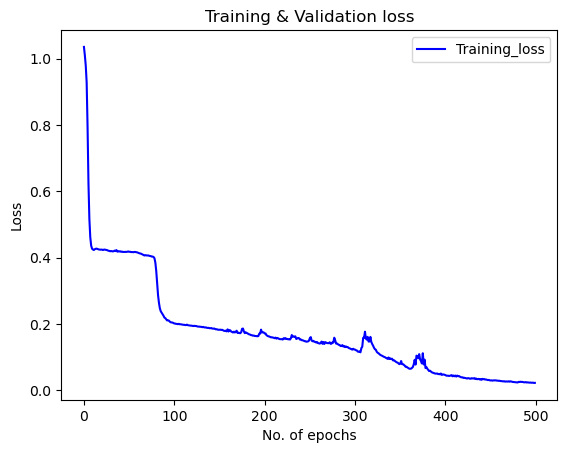

In [122]:
print("Best Loss:",best_loss)
plt_loss_accuracy_fig_2(total_train_loss)

In [123]:
model_cnn_AE = conv_autoencoder().to(device)
pth_path = 'MNIST_0167_AE.pth'
state_dict = torch.load(pth_path)
model_cnn_AE.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
model_cnn_AE.eval()
encoder_AE = model_cnn_AE.encoder
eval_loss = nn.MSELoss(reduction='none')

Load pth from MNIST_0167_AE.pth


See the result of recreating.

Loss: [0.0024298974312841892, 0.0350608192384243, 0.01353108137845993, 0.03896670788526535]


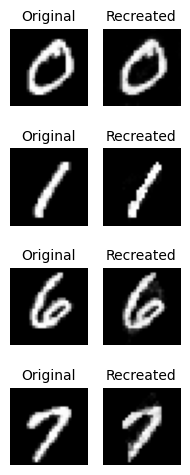

In [124]:
total_output = list()
total_test_loss = list()
for i in range(len(dataset)):
    img, _ = dataset[i]
    img_batch = img.unsqueeze(0)
    output, loss = recreate_img(img_batch, model_cnn_AE, eval_loss)
    total_output.append((img.cpu().detach().numpy().squeeze(0), output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)

plt.figure(figsize=(2, 5))
for i, img_idx in enumerate(range(len(dataset))):
    img, output_img = total_output[img_idx]

    # image subplot
    ax_img = plt.subplot(4, 2, 2 * i + 1)
    ax_img.imshow(img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Original", fontsize=10)
    ax_img = plt.subplot(4, 2, 2 * i + 2)
    ax_img.imshow(output_img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Recreated", fontsize=10)
plt.tight_layout()
plt.show()


In [125]:
AE_total_latent = dict() # list contains np.array()
for img, y in small_dataloader:
    img = img.to(device)
    latent_space = encoder_AE(img)
    print(latent_space.shape)
    AE_total_latent[int(y)] = latent_space.cpu().detach().numpy().squeeze()

torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])


#### 1.4 train a VAE.
* latent space is (batch_size, 1, 1, 1)

In [159]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.enc_out_1 = nn.Sequential(
            nn.Conv2d(48, 1, 3, stride=1),# laten space is  1*1
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            nn.Conv2d(48, 1, 3, stride=1),# laten space is  1*1
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1, 48, 3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 1, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def encode(self, x):
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() # e^(sigma * 0.5)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu) # e * sigma + mu

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x) # get the mu and logvar, but need to get sigma=var^0.5 from logvar 
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar

# VAE的訓練使用的是一種特殊的損失函數，即「重建損失」和「KL 散度（Kullback-Leibler divergence）」的組合，又稱為ELBO。
# 重建損失衡量生成樣本的質量，而KL 散度則衡量潛在變數的分佈與標準正態分佈之間的差異。
def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x) * x.shape[0]
    # KL Divergence = -0.5 * sum(1 + logvar - mu^2 - e^logvar)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    return mse + KLD

In [190]:
# Hyper Parameters
LR = 0.002
IMAGE_SIZE = 28

vae = VAE().to(device)

# set loss function
criterion = nn.MSELoss()
# set optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=LR, betas=(0.9, 0.999))
# Print the model summary
summary(vae, (1, IMAGE_SIZE, IMAGE_SIZE)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 28, 28]               --
├─Sequential: 1-1                        [48, 3, 3]                --
│    └─Conv2d: 2-1                       [12, 14, 14]              204
│    └─ReLU: 2-2                         [12, 14, 14]              --
│    └─Conv2d: 2-3                       [24, 7, 7]                4,632
│    └─ReLU: 2-4                         [24, 7, 7]                --
│    └─Conv2d: 2-5                       [48, 3, 3]                18,480
│    └─ReLU: 2-6                         [48, 3, 3]                --
├─Sequential: 1-2                        [1, 1, 1]                 --
│    └─Conv2d: 2-7                       [1, 1, 1]                 433
│    └─ReLU: 2-8                         [1, 1, 1]                 --
├─Sequential: 1-3                        [1, 1, 1]                 --
│    └─Conv2d: 2-9                       [1, 1, 1]                 433
│    

In [191]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch_3(train_dataloader, model, criterion, optimizer):
    model.train()
    tot_loss = list()
    for x, _ in tqdm(train_dataloader):
        x = x.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        output, mu, logvar = model(x)
        # see loss
        loss = loss_vae(output, x, mu, logvar, criterion) / x.shape[0] # get average on this batch
        loss.backward()
        
        # update the parameters
        optimizer.step()

        tot_loss.append(loss.item())
    return np.mean(tot_loss)

def test_3(test_dataloader, model, criterion):
    tot_loss = []
    model.eval()
    with torch.no_grad():
        for x, _ in tqdm(test_dataloader):
            _, loss = recreate_img_vae(x, model, criterion)  
            tot_loss.append(loss.item())
    return np.mean(tot_loss)

def recreate_img_vae(img_batch, model, criterion):
    model.eval()
    with torch.no_grad():
        img_batch = img_batch.to(device)
        # predicting
        output, mu, logvar = model(img_batch)
        # see loss
        loss = loss_vae(output, img_batch, mu, logvar, criterion) / img_batch.shape[0] # shape: (batch, C, H, W)
    return output, loss  # return each image's loss

In [192]:
# Start training and testing
best_loss = 100
NUM_EPOCHS = 600
# For ploting the trend image
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_loss = train_epoch_3(small_dataloader, vae, criterion, optimizer)
    # record the training data
    total_train_loss.append(train_loss)
    print("Epoch[{:>2d}/{:>2d}] : train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_loss))
    # update model pth when larger val_acc happens
    if(train_loss < best_loss):
        best_loss = train_loss
        save_parameters = True
        if save_parameters:
            path = 'MNIST_0167_VAE.pth'
            torch.save(vae.state_dict(), path)
            print("\t\33[33m==== Save model at epoch {:d} | best_loss = {:.4f} ====\33[0m".format(i+1, best_loss))

# save the final epoch's model
path = 'MNIST_0167_VAE_final_epoch.pth'
torch.save(vae.state_dict(), path)
print("\t\33[33m==== Save FINAL model parameters in {:s} ====\33[0m".format(path))

100%|██████████| 4/4 [00:00<00:00, 144.11it/s]


Epoch[ 1/600] : train_loss = 0.8239
	==== Save model at epoch 1 | best_loss = 0.8239 ====


100%|██████████| 4/4 [00:00<00:00, 142.14it/s]


Epoch[ 2/600] : train_loss = 0.7677
	==== Save model at epoch 2 | best_loss = 0.7677 ====


100%|██████████| 4/4 [00:00<00:00, 168.23it/s]


Epoch[ 3/600] : train_loss = 0.6979
	==== Save model at epoch 3 | best_loss = 0.6979 ====


100%|██████████| 4/4 [00:00<00:00, 167.65it/s]


Epoch[ 4/600] : train_loss = 0.6202
	==== Save model at epoch 4 | best_loss = 0.6202 ====


100%|██████████| 4/4 [00:00<00:00, 171.63it/s]


Epoch[ 5/600] : train_loss = 0.5546
	==== Save model at epoch 5 | best_loss = 0.5546 ====


100%|██████████| 4/4 [00:00<00:00, 166.03it/s]


Epoch[ 6/600] : train_loss = 0.5000
	==== Save model at epoch 6 | best_loss = 0.5000 ====


100%|██████████| 4/4 [00:00<00:00, 171.20it/s]


Epoch[ 7/600] : train_loss = 0.4867
	==== Save model at epoch 7 | best_loss = 0.4867 ====


100%|██████████| 4/4 [00:00<00:00, 181.46it/s]


Epoch[ 8/600] : train_loss = 0.4723
	==== Save model at epoch 8 | best_loss = 0.4723 ====


100%|██████████| 4/4 [00:00<00:00, 155.74it/s]


Epoch[ 9/600] : train_loss = 0.4639
	==== Save model at epoch 9 | best_loss = 0.4639 ====


100%|██████████| 4/4 [00:00<00:00, 160.37it/s]


Epoch[10/600] : train_loss = 0.4573
	==== Save model at epoch 10 | best_loss = 0.4573 ====


100%|██████████| 4/4 [00:00<00:00, 141.56it/s]


Epoch[11/600] : train_loss = 0.4494
	==== Save model at epoch 11 | best_loss = 0.4494 ====


100%|██████████| 4/4 [00:00<00:00, 139.07it/s]


Epoch[12/600] : train_loss = 0.4463
	==== Save model at epoch 12 | best_loss = 0.4463 ====


100%|██████████| 4/4 [00:00<00:00, 152.06it/s]


Epoch[13/600] : train_loss = 0.4423
	==== Save model at epoch 13 | best_loss = 0.4423 ====


100%|██████████| 4/4 [00:00<00:00, 161.15it/s]


Epoch[14/600] : train_loss = 0.4390
	==== Save model at epoch 14 | best_loss = 0.4390 ====


100%|██████████| 4/4 [00:00<00:00, 152.99it/s]


Epoch[15/600] : train_loss = 0.4368
	==== Save model at epoch 15 | best_loss = 0.4368 ====


100%|██████████| 4/4 [00:00<00:00, 170.42it/s]


Epoch[16/600] : train_loss = 0.4350
	==== Save model at epoch 16 | best_loss = 0.4350 ====


100%|██████████| 4/4 [00:00<00:00, 178.92it/s]


Epoch[17/600] : train_loss = 0.4312
	==== Save model at epoch 17 | best_loss = 0.4312 ====


100%|██████████| 4/4 [00:00<00:00, 160.56it/s]


Epoch[18/600] : train_loss = 0.4255
	==== Save model at epoch 18 | best_loss = 0.4255 ====


100%|██████████| 4/4 [00:00<00:00, 145.45it/s]


Epoch[19/600] : train_loss = 0.4200
	==== Save model at epoch 19 | best_loss = 0.4200 ====


100%|██████████| 4/4 [00:00<00:00, 160.07it/s]


Epoch[20/600] : train_loss = 0.4137
	==== Save model at epoch 20 | best_loss = 0.4137 ====


100%|██████████| 4/4 [00:00<00:00, 170.65it/s]


Epoch[21/600] : train_loss = 0.4068
	==== Save model at epoch 21 | best_loss = 0.4068 ====


100%|██████████| 4/4 [00:00<00:00, 174.88it/s]


Epoch[22/600] : train_loss = 0.3998
	==== Save model at epoch 22 | best_loss = 0.3998 ====


100%|██████████| 4/4 [00:00<00:00, 178.60it/s]


Epoch[23/600] : train_loss = 0.3980
	==== Save model at epoch 23 | best_loss = 0.3980 ====


100%|██████████| 4/4 [00:00<00:00, 190.81it/s]


Epoch[24/600] : train_loss = 0.3824
	==== Save model at epoch 24 | best_loss = 0.3824 ====


100%|██████████| 4/4 [00:00<00:00, 165.24it/s]


Epoch[25/600] : train_loss = 0.3831


100%|██████████| 4/4 [00:00<00:00, 161.62it/s]


Epoch[26/600] : train_loss = 0.3684
	==== Save model at epoch 26 | best_loss = 0.3684 ====


100%|██████████| 4/4 [00:00<00:00, 159.30it/s]


Epoch[27/600] : train_loss = 0.3488
	==== Save model at epoch 27 | best_loss = 0.3488 ====


100%|██████████| 4/4 [00:00<00:00, 165.93it/s]


Epoch[28/600] : train_loss = 0.3352
	==== Save model at epoch 28 | best_loss = 0.3352 ====


100%|██████████| 4/4 [00:00<00:00, 188.10it/s]


Epoch[29/600] : train_loss = 0.3220
	==== Save model at epoch 29 | best_loss = 0.3220 ====


100%|██████████| 4/4 [00:00<00:00, 173.50it/s]


Epoch[30/600] : train_loss = 0.3021
	==== Save model at epoch 30 | best_loss = 0.3021 ====


100%|██████████| 4/4 [00:00<00:00, 170.22it/s]


Epoch[31/600] : train_loss = 0.3008
	==== Save model at epoch 31 | best_loss = 0.3008 ====


100%|██████████| 4/4 [00:00<00:00, 172.42it/s]


Epoch[32/600] : train_loss = 0.2739
	==== Save model at epoch 32 | best_loss = 0.2739 ====


100%|██████████| 4/4 [00:00<00:00, 176.65it/s]


Epoch[33/600] : train_loss = 0.2692
	==== Save model at epoch 33 | best_loss = 0.2692 ====


100%|██████████| 4/4 [00:00<00:00, 165.75it/s]


Epoch[34/600] : train_loss = 0.2777


100%|██████████| 4/4 [00:00<00:00, 175.65it/s]


Epoch[35/600] : train_loss = 0.2623
	==== Save model at epoch 35 | best_loss = 0.2623 ====


100%|██████████| 4/4 [00:00<00:00, 186.57it/s]


Epoch[36/600] : train_loss = 0.2496
	==== Save model at epoch 36 | best_loss = 0.2496 ====


100%|██████████| 4/4 [00:00<00:00, 169.84it/s]


Epoch[37/600] : train_loss = 0.2383
	==== Save model at epoch 37 | best_loss = 0.2383 ====


100%|██████████| 4/4 [00:00<00:00, 158.27it/s]


Epoch[38/600] : train_loss = 0.2317
	==== Save model at epoch 38 | best_loss = 0.2317 ====


100%|██████████| 4/4 [00:00<00:00, 174.07it/s]


Epoch[39/600] : train_loss = 0.2391


100%|██████████| 4/4 [00:00<00:00, 191.17it/s]


Epoch[40/600] : train_loss = 0.2453


100%|██████████| 4/4 [00:00<00:00, 187.63it/s]


Epoch[41/600] : train_loss = 0.2411


100%|██████████| 4/4 [00:00<00:00, 169.01it/s]


Epoch[42/600] : train_loss = 0.2255
	==== Save model at epoch 42 | best_loss = 0.2255 ====


100%|██████████| 4/4 [00:00<00:00, 165.42it/s]


Epoch[43/600] : train_loss = 0.2291


100%|██████████| 4/4 [00:00<00:00, 165.00it/s]


Epoch[44/600] : train_loss = 0.2395


100%|██████████| 4/4 [00:00<00:00, 174.99it/s]


Epoch[45/600] : train_loss = 0.2310


100%|██████████| 4/4 [00:00<00:00, 170.06it/s]


Epoch[46/600] : train_loss = 0.2474


100%|██████████| 4/4 [00:00<00:00, 170.65it/s]


Epoch[47/600] : train_loss = 0.2380


100%|██████████| 4/4 [00:00<00:00, 182.63it/s]


Epoch[48/600] : train_loss = 0.2256


100%|██████████| 4/4 [00:00<00:00, 178.13it/s]


Epoch[49/600] : train_loss = 0.2282


100%|██████████| 4/4 [00:00<00:00, 173.93it/s]


Epoch[50/600] : train_loss = 0.2131
	==== Save model at epoch 50 | best_loss = 0.2131 ====


100%|██████████| 4/4 [00:00<00:00, 180.77it/s]


Epoch[51/600] : train_loss = 0.2136


100%|██████████| 4/4 [00:00<00:00, 172.85it/s]


Epoch[52/600] : train_loss = 0.2243


100%|██████████| 4/4 [00:00<00:00, 168.08it/s]


Epoch[53/600] : train_loss = 0.2518


100%|██████████| 4/4 [00:00<00:00, 186.90it/s]


Epoch[54/600] : train_loss = 0.2282


100%|██████████| 4/4 [00:00<00:00, 180.92it/s]


Epoch[55/600] : train_loss = 0.2256


100%|██████████| 4/4 [00:00<00:00, 179.99it/s]


Epoch[56/600] : train_loss = 0.2362


100%|██████████| 4/4 [00:00<00:00, 155.62it/s]


Epoch[57/600] : train_loss = 0.2241


100%|██████████| 4/4 [00:00<00:00, 181.45it/s]


Epoch[58/600] : train_loss = 0.2137


100%|██████████| 4/4 [00:00<00:00, 170.25it/s]


Epoch[59/600] : train_loss = 0.2119
	==== Save model at epoch 59 | best_loss = 0.2119 ====


100%|██████████| 4/4 [00:00<00:00, 195.71it/s]


Epoch[60/600] : train_loss = 0.2270


100%|██████████| 4/4 [00:00<00:00, 158.03it/s]


Epoch[61/600] : train_loss = 0.2048
	==== Save model at epoch 61 | best_loss = 0.2048 ====


100%|██████████| 4/4 [00:00<00:00, 167.79it/s]


Epoch[62/600] : train_loss = 0.2136


100%|██████████| 4/4 [00:00<00:00, 175.44it/s]


Epoch[63/600] : train_loss = 0.2080


100%|██████████| 4/4 [00:00<00:00, 159.34it/s]


Epoch[64/600] : train_loss = 0.2414


100%|██████████| 4/4 [00:00<00:00, 185.58it/s]


Epoch[65/600] : train_loss = 0.2317


100%|██████████| 4/4 [00:00<00:00, 178.49it/s]


Epoch[66/600] : train_loss = 0.2313


100%|██████████| 4/4 [00:00<00:00, 170.10it/s]


Epoch[67/600] : train_loss = 0.2052


100%|██████████| 4/4 [00:00<00:00, 148.75it/s]


Epoch[68/600] : train_loss = 0.2164


100%|██████████| 4/4 [00:00<00:00, 155.28it/s]


Epoch[69/600] : train_loss = 0.2051


100%|██████████| 4/4 [00:00<00:00, 170.16it/s]


Epoch[70/600] : train_loss = 0.2126


100%|██████████| 4/4 [00:00<00:00, 168.84it/s]


Epoch[71/600] : train_loss = 0.2070


100%|██████████| 4/4 [00:00<00:00, 163.55it/s]


Epoch[72/600] : train_loss = 0.2118


100%|██████████| 4/4 [00:00<00:00, 177.30it/s]


Epoch[73/600] : train_loss = 0.2133


100%|██████████| 4/4 [00:00<00:00, 189.44it/s]


Epoch[74/600] : train_loss = 0.2086


100%|██████████| 4/4 [00:00<00:00, 166.78it/s]


Epoch[75/600] : train_loss = 0.2054


100%|██████████| 4/4 [00:00<00:00, 168.95it/s]


Epoch[76/600] : train_loss = 0.2037
	==== Save model at epoch 76 | best_loss = 0.2037 ====


100%|██████████| 4/4 [00:00<00:00, 144.26it/s]


Epoch[77/600] : train_loss = 0.2134


100%|██████████| 4/4 [00:00<00:00, 103.24it/s]


Epoch[78/600] : train_loss = 0.2257


100%|██████████| 4/4 [00:00<00:00, 163.85it/s]


Epoch[79/600] : train_loss = 0.2241


100%|██████████| 4/4 [00:00<00:00, 126.62it/s]


Epoch[80/600] : train_loss = 0.2128


100%|██████████| 4/4 [00:00<00:00, 184.91it/s]


Epoch[81/600] : train_loss = 0.2029
	==== Save model at epoch 81 | best_loss = 0.2029 ====


100%|██████████| 4/4 [00:00<00:00, 162.43it/s]


Epoch[82/600] : train_loss = 0.2019
	==== Save model at epoch 82 | best_loss = 0.2019 ====


100%|██████████| 4/4 [00:00<00:00, 164.20it/s]


Epoch[83/600] : train_loss = 0.2366


100%|██████████| 4/4 [00:00<00:00, 142.58it/s]


Epoch[84/600] : train_loss = 0.2103


100%|██████████| 4/4 [00:00<00:00, 161.28it/s]


Epoch[85/600] : train_loss = 0.2176


100%|██████████| 4/4 [00:00<00:00, 178.66it/s]


Epoch[86/600] : train_loss = 0.2245


100%|██████████| 4/4 [00:00<00:00, 156.02it/s]


Epoch[87/600] : train_loss = 0.2160


100%|██████████| 4/4 [00:00<00:00, 168.15it/s]


Epoch[88/600] : train_loss = 0.2213


100%|██████████| 4/4 [00:00<00:00, 155.53it/s]


Epoch[89/600] : train_loss = 0.1979
	==== Save model at epoch 89 | best_loss = 0.1979 ====


100%|██████████| 4/4 [00:00<00:00, 155.12it/s]


Epoch[90/600] : train_loss = 0.2116


100%|██████████| 4/4 [00:00<00:00, 148.88it/s]


Epoch[91/600] : train_loss = 0.2047


100%|██████████| 4/4 [00:00<00:00, 160.52it/s]


Epoch[92/600] : train_loss = 0.2007


100%|██████████| 4/4 [00:00<00:00, 167.22it/s]


Epoch[93/600] : train_loss = 0.2119


100%|██████████| 4/4 [00:00<00:00, 152.66it/s]


Epoch[94/600] : train_loss = 0.2138


100%|██████████| 4/4 [00:00<00:00, 168.49it/s]


Epoch[95/600] : train_loss = 0.2169


100%|██████████| 4/4 [00:00<00:00, 161.42it/s]


Epoch[96/600] : train_loss = 0.2048


100%|██████████| 4/4 [00:00<00:00, 109.06it/s]


Epoch[97/600] : train_loss = 0.2053


100%|██████████| 4/4 [00:00<00:00, 155.30it/s]


Epoch[98/600] : train_loss = 0.1980


100%|██████████| 4/4 [00:00<00:00, 140.61it/s]


Epoch[99/600] : train_loss = 0.2153


100%|██████████| 4/4 [00:00<00:00, 143.19it/s]


Epoch[100/600] : train_loss = 0.2018


100%|██████████| 4/4 [00:00<00:00, 91.96it/s]


Epoch[101/600] : train_loss = 0.2063


100%|██████████| 4/4 [00:00<00:00, 111.99it/s]


Epoch[102/600] : train_loss = 0.1959
	==== Save model at epoch 102 | best_loss = 0.1959 ====


100%|██████████| 4/4 [00:00<00:00, 134.53it/s]


Epoch[103/600] : train_loss = 0.2034


100%|██████████| 4/4 [00:00<00:00, 181.97it/s]


Epoch[104/600] : train_loss = 0.2021


100%|██████████| 4/4 [00:00<00:00, 185.28it/s]


Epoch[105/600] : train_loss = 0.1968


100%|██████████| 4/4 [00:00<00:00, 176.64it/s]


Epoch[106/600] : train_loss = 0.2098


100%|██████████| 4/4 [00:00<00:00, 157.96it/s]


Epoch[107/600] : train_loss = 0.2007


100%|██████████| 4/4 [00:00<00:00, 165.91it/s]


Epoch[108/600] : train_loss = 0.2058


100%|██████████| 4/4 [00:00<00:00, 157.14it/s]


Epoch[109/600] : train_loss = 0.2162


100%|██████████| 4/4 [00:00<00:00, 152.65it/s]


Epoch[110/600] : train_loss = 0.2198


100%|██████████| 4/4 [00:00<00:00, 164.65it/s]


Epoch[111/600] : train_loss = 0.2137


100%|██████████| 4/4 [00:00<00:00, 167.42it/s]


Epoch[112/600] : train_loss = 0.2107


100%|██████████| 4/4 [00:00<00:00, 168.13it/s]


Epoch[113/600] : train_loss = 0.2049


100%|██████████| 4/4 [00:00<00:00, 189.35it/s]


Epoch[114/600] : train_loss = 0.2078


100%|██████████| 4/4 [00:00<00:00, 150.85it/s]


Epoch[115/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 182.51it/s]


Epoch[116/600] : train_loss = 0.2161


100%|██████████| 4/4 [00:00<00:00, 187.57it/s]


Epoch[117/600] : train_loss = 0.2068


100%|██████████| 4/4 [00:00<00:00, 172.23it/s]


Epoch[118/600] : train_loss = 0.2121


100%|██████████| 4/4 [00:00<00:00, 143.56it/s]


Epoch[119/600] : train_loss = 0.2044


100%|██████████| 4/4 [00:00<00:00, 174.65it/s]


Epoch[120/600] : train_loss = 0.2004


100%|██████████| 4/4 [00:00<00:00, 183.05it/s]


Epoch[121/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 147.07it/s]


Epoch[122/600] : train_loss = 0.2062


100%|██████████| 4/4 [00:00<00:00, 196.74it/s]


Epoch[123/600] : train_loss = 0.2033


100%|██████████| 4/4 [00:00<00:00, 149.09it/s]


Epoch[124/600] : train_loss = 0.1938
	==== Save model at epoch 124 | best_loss = 0.1938 ====


100%|██████████| 4/4 [00:00<00:00, 161.63it/s]


Epoch[125/600] : train_loss = 0.1934
	==== Save model at epoch 125 | best_loss = 0.1934 ====


100%|██████████| 4/4 [00:00<00:00, 173.21it/s]


Epoch[126/600] : train_loss = 0.2031


100%|██████████| 4/4 [00:00<00:00, 169.31it/s]


Epoch[127/600] : train_loss = 0.2102


100%|██████████| 4/4 [00:00<00:00, 159.73it/s]


Epoch[128/600] : train_loss = 0.2143


100%|██████████| 4/4 [00:00<00:00, 160.44it/s]


Epoch[129/600] : train_loss = 0.2138


100%|██████████| 4/4 [00:00<00:00, 156.25it/s]


Epoch[130/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 151.82it/s]


Epoch[131/600] : train_loss = 0.2095


100%|██████████| 4/4 [00:00<00:00, 168.43it/s]


Epoch[132/600] : train_loss = 0.1950


100%|██████████| 4/4 [00:00<00:00, 171.75it/s]


Epoch[133/600] : train_loss = 0.2205


100%|██████████| 4/4 [00:00<00:00, 160.75it/s]


Epoch[134/600] : train_loss = 0.2006


100%|██████████| 4/4 [00:00<00:00, 115.36it/s]


Epoch[135/600] : train_loss = 0.2009


100%|██████████| 4/4 [00:00<00:00, 82.86it/s]


Epoch[136/600] : train_loss = 0.2119


100%|██████████| 4/4 [00:00<00:00, 162.81it/s]


Epoch[137/600] : train_loss = 0.1985


100%|██████████| 4/4 [00:00<00:00, 146.71it/s]


Epoch[138/600] : train_loss = 0.2003


100%|██████████| 4/4 [00:00<00:00, 175.49it/s]


Epoch[139/600] : train_loss = 0.1961


100%|██████████| 4/4 [00:00<00:00, 171.30it/s]


Epoch[140/600] : train_loss = 0.2185


100%|██████████| 4/4 [00:00<00:00, 167.22it/s]


Epoch[141/600] : train_loss = 0.2129


100%|██████████| 4/4 [00:00<00:00, 181.29it/s]


Epoch[142/600] : train_loss = 0.1973


100%|██████████| 4/4 [00:00<00:00, 162.22it/s]


Epoch[143/600] : train_loss = 0.2079


100%|██████████| 4/4 [00:00<00:00, 180.04it/s]


Epoch[144/600] : train_loss = 0.2032


100%|██████████| 4/4 [00:00<00:00, 105.18it/s]


Epoch[145/600] : train_loss = 0.2096


100%|██████████| 4/4 [00:00<00:00, 155.45it/s]


Epoch[146/600] : train_loss = 0.2146


100%|██████████| 4/4 [00:00<00:00, 161.23it/s]


Epoch[147/600] : train_loss = 0.1994


100%|██████████| 4/4 [00:00<00:00, 190.87it/s]


Epoch[148/600] : train_loss = 0.2017


100%|██████████| 4/4 [00:00<00:00, 174.70it/s]


Epoch[149/600] : train_loss = 0.2097


100%|██████████| 4/4 [00:00<00:00, 161.43it/s]


Epoch[150/600] : train_loss = 0.2032


100%|██████████| 4/4 [00:00<00:00, 167.02it/s]


Epoch[151/600] : train_loss = 0.2041


100%|██████████| 4/4 [00:00<00:00, 162.35it/s]


Epoch[152/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 166.87it/s]


Epoch[153/600] : train_loss = 0.2104


100%|██████████| 4/4 [00:00<00:00, 164.29it/s]


Epoch[154/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 149.07it/s]


Epoch[155/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 165.98it/s]


Epoch[156/600] : train_loss = 0.1991


100%|██████████| 4/4 [00:00<00:00, 186.98it/s]


Epoch[157/600] : train_loss = 0.1964


100%|██████████| 4/4 [00:00<00:00, 138.78it/s]


Epoch[158/600] : train_loss = 0.2001


100%|██████████| 4/4 [00:00<00:00, 177.40it/s]


Epoch[159/600] : train_loss = 0.2020


100%|██████████| 4/4 [00:00<00:00, 166.81it/s]


Epoch[160/600] : train_loss = 0.2078


100%|██████████| 4/4 [00:00<00:00, 167.24it/s]


Epoch[161/600] : train_loss = 0.1940


100%|██████████| 4/4 [00:00<00:00, 173.33it/s]


Epoch[162/600] : train_loss = 0.2133


100%|██████████| 4/4 [00:00<00:00, 192.79it/s]


Epoch[163/600] : train_loss = 0.2264


100%|██████████| 4/4 [00:00<00:00, 158.03it/s]


Epoch[164/600] : train_loss = 0.2039


100%|██████████| 4/4 [00:00<00:00, 152.35it/s]


Epoch[165/600] : train_loss = 0.2078


100%|██████████| 4/4 [00:00<00:00, 155.67it/s]


Epoch[166/600] : train_loss = 0.2060


100%|██████████| 4/4 [00:00<00:00, 165.70it/s]


Epoch[167/600] : train_loss = 0.1956


100%|██████████| 4/4 [00:00<00:00, 99.19it/s]


Epoch[168/600] : train_loss = 0.2107


100%|██████████| 4/4 [00:00<00:00, 104.43it/s]


Epoch[169/600] : train_loss = 0.2028


100%|██████████| 4/4 [00:00<00:00, 135.73it/s]


Epoch[170/600] : train_loss = 0.2029


100%|██████████| 4/4 [00:00<00:00, 166.24it/s]


Epoch[171/600] : train_loss = 0.1991


100%|██████████| 4/4 [00:00<00:00, 170.46it/s]


Epoch[172/600] : train_loss = 0.2016


100%|██████████| 4/4 [00:00<00:00, 180.78it/s]


Epoch[173/600] : train_loss = 0.1970


100%|██████████| 4/4 [00:00<00:00, 148.51it/s]


Epoch[174/600] : train_loss = 0.2119


100%|██████████| 4/4 [00:00<00:00, 174.57it/s]


Epoch[175/600] : train_loss = 0.1996


100%|██████████| 4/4 [00:00<00:00, 155.24it/s]


Epoch[176/600] : train_loss = 0.2091


100%|██████████| 4/4 [00:00<00:00, 169.79it/s]


Epoch[177/600] : train_loss = 0.2108


100%|██████████| 4/4 [00:00<00:00, 160.08it/s]


Epoch[178/600] : train_loss = 0.1920
	==== Save model at epoch 178 | best_loss = 0.1920 ====


100%|██████████| 4/4 [00:00<00:00, 181.44it/s]


Epoch[179/600] : train_loss = 0.1952


100%|██████████| 4/4 [00:00<00:00, 160.94it/s]


Epoch[180/600] : train_loss = 0.1954


100%|██████████| 4/4 [00:00<00:00, 184.89it/s]


Epoch[181/600] : train_loss = 0.2026


100%|██████████| 4/4 [00:00<00:00, 112.38it/s]


Epoch[182/600] : train_loss = 0.2177


100%|██████████| 4/4 [00:00<00:00, 183.50it/s]


Epoch[183/600] : train_loss = 0.2008


100%|██████████| 4/4 [00:00<00:00, 167.92it/s]


Epoch[184/600] : train_loss = 0.2159


100%|██████████| 4/4 [00:00<00:00, 152.85it/s]


Epoch[185/600] : train_loss = 0.2006


100%|██████████| 4/4 [00:00<00:00, 161.75it/s]


Epoch[186/600] : train_loss = 0.2044


100%|██████████| 4/4 [00:00<00:00, 177.04it/s]


Epoch[187/600] : train_loss = 0.2090


100%|██████████| 4/4 [00:00<00:00, 156.31it/s]


Epoch[188/600] : train_loss = 0.2053


100%|██████████| 4/4 [00:00<00:00, 156.07it/s]


Epoch[189/600] : train_loss = 0.2095


100%|██████████| 4/4 [00:00<00:00, 172.32it/s]


Epoch[190/600] : train_loss = 0.2051


100%|██████████| 4/4 [00:00<00:00, 176.21it/s]


Epoch[191/600] : train_loss = 0.2091


100%|██████████| 4/4 [00:00<00:00, 166.92it/s]


Epoch[192/600] : train_loss = 0.1977


100%|██████████| 4/4 [00:00<00:00, 183.26it/s]


Epoch[193/600] : train_loss = 0.1936


100%|██████████| 4/4 [00:00<00:00, 166.95it/s]


Epoch[194/600] : train_loss = 0.1992


100%|██████████| 4/4 [00:00<00:00, 145.05it/s]


Epoch[195/600] : train_loss = 0.1994


100%|██████████| 4/4 [00:00<00:00, 176.20it/s]


Epoch[196/600] : train_loss = 0.2053


100%|██████████| 4/4 [00:00<00:00, 152.24it/s]


Epoch[197/600] : train_loss = 0.2052


100%|██████████| 4/4 [00:00<00:00, 183.19it/s]


Epoch[198/600] : train_loss = 0.2037


100%|██████████| 4/4 [00:00<00:00, 170.83it/s]


Epoch[199/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 157.45it/s]


Epoch[200/600] : train_loss = 0.2061


100%|██████████| 4/4 [00:00<00:00, 155.00it/s]


Epoch[201/600] : train_loss = 0.1938


100%|██████████| 4/4 [00:00<00:00, 172.23it/s]


Epoch[202/600] : train_loss = 0.2032


100%|██████████| 4/4 [00:00<00:00, 171.93it/s]


Epoch[203/600] : train_loss = 0.2022


100%|██████████| 4/4 [00:00<00:00, 182.56it/s]


Epoch[204/600] : train_loss = 0.1979


100%|██████████| 4/4 [00:00<00:00, 89.09it/s]


Epoch[205/600] : train_loss = 0.2113


100%|██████████| 4/4 [00:00<00:00, 119.63it/s]


Epoch[206/600] : train_loss = 0.1977


100%|██████████| 4/4 [00:00<00:00, 125.46it/s]


Epoch[207/600] : train_loss = 0.2053


100%|██████████| 4/4 [00:00<00:00, 173.42it/s]


Epoch[208/600] : train_loss = 0.1953


100%|██████████| 4/4 [00:00<00:00, 179.28it/s]


Epoch[209/600] : train_loss = 0.1977


100%|██████████| 4/4 [00:00<00:00, 170.22it/s]


Epoch[210/600] : train_loss = 0.1981


100%|██████████| 4/4 [00:00<00:00, 165.98it/s]


Epoch[211/600] : train_loss = 0.2148


100%|██████████| 4/4 [00:00<00:00, 141.34it/s]


Epoch[212/600] : train_loss = 0.2050


100%|██████████| 4/4 [00:00<00:00, 148.93it/s]


Epoch[213/600] : train_loss = 0.1975


100%|██████████| 4/4 [00:00<00:00, 119.03it/s]


Epoch[214/600] : train_loss = 0.2078


100%|██████████| 4/4 [00:00<00:00, 149.17it/s]


Epoch[215/600] : train_loss = 0.1920
	==== Save model at epoch 215 | best_loss = 0.1920 ====


100%|██████████| 4/4 [00:00<00:00, 141.25it/s]


Epoch[216/600] : train_loss = 0.2093


100%|██████████| 4/4 [00:00<00:00, 177.92it/s]


Epoch[217/600] : train_loss = 0.1979


100%|██████████| 4/4 [00:00<00:00, 185.67it/s]


Epoch[218/600] : train_loss = 0.2083


100%|██████████| 4/4 [00:00<00:00, 154.53it/s]


Epoch[219/600] : train_loss = 0.2038


100%|██████████| 4/4 [00:00<00:00, 168.67it/s]


Epoch[220/600] : train_loss = 0.1917
	==== Save model at epoch 220 | best_loss = 0.1917 ====


100%|██████████| 4/4 [00:00<00:00, 166.25it/s]


Epoch[221/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 148.83it/s]


Epoch[222/600] : train_loss = 0.2012


100%|██████████| 4/4 [00:00<00:00, 156.79it/s]


Epoch[223/600] : train_loss = 0.1948


100%|██████████| 4/4 [00:00<00:00, 162.35it/s]


Epoch[224/600] : train_loss = 0.2260


100%|██████████| 4/4 [00:00<00:00, 177.04it/s]


Epoch[225/600] : train_loss = 0.2096


100%|██████████| 4/4 [00:00<00:00, 176.67it/s]


Epoch[226/600] : train_loss = 0.1983


100%|██████████| 4/4 [00:00<00:00, 159.80it/s]


Epoch[227/600] : train_loss = 0.1981


100%|██████████| 4/4 [00:00<00:00, 141.87it/s]


Epoch[228/600] : train_loss = 0.1997


100%|██████████| 4/4 [00:00<00:00, 182.82it/s]


Epoch[229/600] : train_loss = 0.2005


100%|██████████| 4/4 [00:00<00:00, 185.12it/s]


Epoch[230/600] : train_loss = 0.1990


100%|██████████| 4/4 [00:00<00:00, 159.96it/s]


Epoch[231/600] : train_loss = 0.2116


100%|██████████| 4/4 [00:00<00:00, 194.41it/s]


Epoch[232/600] : train_loss = 0.2073


100%|██████████| 4/4 [00:00<00:00, 179.64it/s]


Epoch[233/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 161.89it/s]


Epoch[234/600] : train_loss = 0.1975


100%|██████████| 4/4 [00:00<00:00, 180.53it/s]


Epoch[235/600] : train_loss = 0.1944


100%|██████████| 4/4 [00:00<00:00, 161.48it/s]


Epoch[236/600] : train_loss = 0.2075


100%|██████████| 4/4 [00:00<00:00, 180.83it/s]


Epoch[237/600] : train_loss = 0.1944


100%|██████████| 4/4 [00:00<00:00, 176.60it/s]

Epoch[238/600] : train_loss = 0.1964

100%|██████████| 4/4 [00:00<00:00, 156.68it/s]


Epoch[239/600] : train_loss = 0.1938


100%|██████████| 4/4 [00:00<00:00, 148.36it/s]


Epoch[240/600] : train_loss = 0.2105


100%|██████████| 4/4 [00:00<00:00, 165.33it/s]


Epoch[241/600] : train_loss = 0.2075


100%|██████████| 4/4 [00:00<00:00, 100.05it/s]


Epoch[242/600] : train_loss = 0.1942


100%|██████████| 4/4 [00:00<00:00, 78.21it/s]


Epoch[243/600] : train_loss = 0.2125


100%|██████████| 4/4 [00:00<00:00, 169.53it/s]


Epoch[244/600] : train_loss = 0.1993


100%|██████████| 4/4 [00:00<00:00, 125.31it/s]


Epoch[245/600] : train_loss = 0.2140


100%|██████████| 4/4 [00:00<00:00, 153.52it/s]


Epoch[246/600] : train_loss = 0.2009


100%|██████████| 4/4 [00:00<00:00, 158.15it/s]


Epoch[247/600] : train_loss = 0.2065


100%|██████████| 4/4 [00:00<00:00, 151.66it/s]


Epoch[248/600] : train_loss = 0.2052


100%|██████████| 4/4 [00:00<00:00, 172.76it/s]


Epoch[249/600] : train_loss = 0.1901
	==== Save model at epoch 249 | best_loss = 0.1901 ====


100%|██████████| 4/4 [00:00<00:00, 163.54it/s]


Epoch[250/600] : train_loss = 0.2065


100%|██████████| 4/4 [00:00<00:00, 166.36it/s]


Epoch[251/600] : train_loss = 0.2111


100%|██████████| 4/4 [00:00<00:00, 133.13it/s]


Epoch[252/600] : train_loss = 0.1981


100%|██████████| 4/4 [00:00<00:00, 163.38it/s]


Epoch[253/600] : train_loss = 0.2015


100%|██████████| 4/4 [00:00<00:00, 179.47it/s]


Epoch[254/600] : train_loss = 0.2047


100%|██████████| 4/4 [00:00<00:00, 186.08it/s]


Epoch[255/600] : train_loss = 0.2032


100%|██████████| 4/4 [00:00<00:00, 160.78it/s]


Epoch[256/600] : train_loss = 0.1904


100%|██████████| 4/4 [00:00<00:00, 174.14it/s]


Epoch[257/600] : train_loss = 0.1954


100%|██████████| 4/4 [00:00<00:00, 175.57it/s]


Epoch[258/600] : train_loss = 0.2117


100%|██████████| 4/4 [00:00<00:00, 170.69it/s]


Epoch[259/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 193.51it/s]


Epoch[260/600] : train_loss = 0.2064


100%|██████████| 4/4 [00:00<00:00, 178.94it/s]


Epoch[261/600] : train_loss = 0.1950


100%|██████████| 4/4 [00:00<00:00, 178.15it/s]


Epoch[262/600] : train_loss = 0.2006


100%|██████████| 4/4 [00:00<00:00, 158.77it/s]


Epoch[263/600] : train_loss = 0.2007


100%|██████████| 4/4 [00:00<00:00, 163.21it/s]


Epoch[264/600] : train_loss = 0.1997


100%|██████████| 4/4 [00:00<00:00, 177.16it/s]


Epoch[265/600] : train_loss = 0.1979


100%|██████████| 4/4 [00:00<00:00, 165.11it/s]


Epoch[266/600] : train_loss = 0.2025


100%|██████████| 4/4 [00:00<00:00, 181.39it/s]


Epoch[267/600] : train_loss = 0.2003


100%|██████████| 4/4 [00:00<00:00, 184.16it/s]


Epoch[268/600] : train_loss = 0.1990


100%|██████████| 4/4 [00:00<00:00, 160.20it/s]


Epoch[269/600] : train_loss = 0.2167


100%|██████████| 4/4 [00:00<00:00, 155.22it/s]


Epoch[270/600] : train_loss = 0.2077


100%|██████████| 4/4 [00:00<00:00, 139.43it/s]


Epoch[271/600] : train_loss = 0.2097


100%|██████████| 4/4 [00:00<00:00, 150.70it/s]


Epoch[272/600] : train_loss = 0.1986


100%|██████████| 4/4 [00:00<00:00, 135.45it/s]


Epoch[273/600] : train_loss = 0.1988


100%|██████████| 4/4 [00:00<00:00, 176.56it/s]


Epoch[274/600] : train_loss = 0.1982


100%|██████████| 4/4 [00:00<00:00, 187.03it/s]


Epoch[275/600] : train_loss = 0.2005


100%|██████████| 4/4 [00:00<00:00, 173.50it/s]


Epoch[276/600] : train_loss = 0.1999


100%|██████████| 4/4 [00:00<00:00, 191.87it/s]


Epoch[277/600] : train_loss = 0.2047


100%|██████████| 4/4 [00:00<00:00, 181.37it/s]


Epoch[278/600] : train_loss = 0.2006


100%|██████████| 4/4 [00:00<00:00, 168.84it/s]


Epoch[279/600] : train_loss = 0.1980


100%|██████████| 4/4 [00:00<00:00, 164.86it/s]


Epoch[280/600] : train_loss = 0.1964


100%|██████████| 4/4 [00:00<00:00, 185.95it/s]


Epoch[281/600] : train_loss = 0.2102


100%|██████████| 4/4 [00:00<00:00, 172.48it/s]


Epoch[282/600] : train_loss = 0.2011


100%|██████████| 4/4 [00:00<00:00, 182.80it/s]


Epoch[283/600] : train_loss = 0.2054


100%|██████████| 4/4 [00:00<00:00, 152.23it/s]


Epoch[284/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 200.90it/s]


Epoch[285/600] : train_loss = 0.2011


100%|██████████| 4/4 [00:00<00:00, 170.74it/s]


Epoch[286/600] : train_loss = 0.1911


100%|██████████| 4/4 [00:00<00:00, 167.58it/s]


Epoch[287/600] : train_loss = 0.1967


100%|██████████| 4/4 [00:00<00:00, 168.30it/s]


Epoch[288/600] : train_loss = 0.2035


100%|██████████| 4/4 [00:00<00:00, 189.09it/s]


Epoch[289/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 167.29it/s]


Epoch[290/600] : train_loss = 0.1965


100%|██████████| 4/4 [00:00<00:00, 166.80it/s]


Epoch[291/600] : train_loss = 0.2110


100%|██████████| 4/4 [00:00<00:00, 170.13it/s]


Epoch[292/600] : train_loss = 0.2096


100%|██████████| 4/4 [00:00<00:00, 175.13it/s]


Epoch[293/600] : train_loss = 0.1987


100%|██████████| 4/4 [00:00<00:00, 203.98it/s]


Epoch[294/600] : train_loss = 0.2060


100%|██████████| 4/4 [00:00<00:00, 167.75it/s]


Epoch[295/600] : train_loss = 0.1932


100%|██████████| 4/4 [00:00<00:00, 157.51it/s]


Epoch[296/600] : train_loss = 0.2063


100%|██████████| 4/4 [00:00<00:00, 184.24it/s]


Epoch[297/600] : train_loss = 0.2064


100%|██████████| 4/4 [00:00<00:00, 188.36it/s]


Epoch[298/600] : train_loss = 0.2098


100%|██████████| 4/4 [00:00<00:00, 172.19it/s]


Epoch[299/600] : train_loss = 0.2035


100%|██████████| 4/4 [00:00<00:00, 188.13it/s]


Epoch[300/600] : train_loss = 0.1946


100%|██████████| 4/4 [00:00<00:00, 165.00it/s]


Epoch[301/600] : train_loss = 0.1969


100%|██████████| 4/4 [00:00<00:00, 206.99it/s]


Epoch[302/600] : train_loss = 0.2017


100%|██████████| 4/4 [00:00<00:00, 165.18it/s]


Epoch[303/600] : train_loss = 0.2015


100%|██████████| 4/4 [00:00<00:00, 153.21it/s]


Epoch[304/600] : train_loss = 0.1971


100%|██████████| 4/4 [00:00<00:00, 104.26it/s]


Epoch[305/600] : train_loss = 0.2066


100%|██████████| 4/4 [00:00<00:00, 131.67it/s]


Epoch[306/600] : train_loss = 0.2090


100%|██████████| 4/4 [00:00<00:00, 142.23it/s]


Epoch[307/600] : train_loss = 0.2134


100%|██████████| 4/4 [00:00<00:00, 185.46it/s]


Epoch[308/600] : train_loss = 0.1977


100%|██████████| 4/4 [00:00<00:00, 175.24it/s]


Epoch[309/600] : train_loss = 0.1985


100%|██████████| 4/4 [00:00<00:00, 190.71it/s]


Epoch[310/600] : train_loss = 0.2030


100%|██████████| 4/4 [00:00<00:00, 198.86it/s]


Epoch[311/600] : train_loss = 0.2046


100%|██████████| 4/4 [00:00<00:00, 175.61it/s]


Epoch[312/600] : train_loss = 0.2077


100%|██████████| 4/4 [00:00<00:00, 199.37it/s]


Epoch[313/600] : train_loss = 0.2016


100%|██████████| 4/4 [00:00<00:00, 198.85it/s]


Epoch[314/600] : train_loss = 0.1985


100%|██████████| 4/4 [00:00<00:00, 159.08it/s]


Epoch[315/600] : train_loss = 0.2042


100%|██████████| 4/4 [00:00<00:00, 190.44it/s]


Epoch[316/600] : train_loss = 0.1979


100%|██████████| 4/4 [00:00<00:00, 174.42it/s]


Epoch[317/600] : train_loss = 0.1945


100%|██████████| 4/4 [00:00<00:00, 164.12it/s]


Epoch[318/600] : train_loss = 0.2014


100%|██████████| 4/4 [00:00<00:00, 195.91it/s]


Epoch[319/600] : train_loss = 0.2042


100%|██████████| 4/4 [00:00<00:00, 189.28it/s]


Epoch[320/600] : train_loss = 0.2057


100%|██████████| 4/4 [00:00<00:00, 172.48it/s]


Epoch[321/600] : train_loss = 0.2024


100%|██████████| 4/4 [00:00<00:00, 193.23it/s]


Epoch[322/600] : train_loss = 0.1998


100%|██████████| 4/4 [00:00<00:00, 184.86it/s]


Epoch[323/600] : train_loss = 0.1954


100%|██████████| 4/4 [00:00<00:00, 159.14it/s]


Epoch[324/600] : train_loss = 0.2017


100%|██████████| 4/4 [00:00<00:00, 158.92it/s]


Epoch[325/600] : train_loss = 0.2017


100%|██████████| 4/4 [00:00<00:00, 191.42it/s]


Epoch[326/600] : train_loss = 0.1984


100%|██████████| 4/4 [00:00<00:00, 168.94it/s]


Epoch[327/600] : train_loss = 0.1986


100%|██████████| 4/4 [00:00<00:00, 178.91it/s]


Epoch[328/600] : train_loss = 0.2017


100%|██████████| 4/4 [00:00<00:00, 170.40it/s]


Epoch[329/600] : train_loss = 0.1982


100%|██████████| 4/4 [00:00<00:00, 184.35it/s]


Epoch[330/600] : train_loss = 0.2033


100%|██████████| 4/4 [00:00<00:00, 164.71it/s]


Epoch[331/600] : train_loss = 0.1909


100%|██████████| 4/4 [00:00<00:00, 162.35it/s]


Epoch[332/600] : train_loss = 0.2033


100%|██████████| 4/4 [00:00<00:00, 168.54it/s]


Epoch[333/600] : train_loss = 0.1887
	==== Save model at epoch 333 | best_loss = 0.1887 ====


100%|██████████| 4/4 [00:00<00:00, 149.50it/s]


Epoch[334/600] : train_loss = 0.1984


100%|██████████| 4/4 [00:00<00:00, 186.52it/s]


Epoch[335/600] : train_loss = 0.1933


100%|██████████| 4/4 [00:00<00:00, 180.32it/s]


Epoch[336/600] : train_loss = 0.2067


100%|██████████| 4/4 [00:00<00:00, 188.24it/s]


Epoch[337/600] : train_loss = 0.2019


100%|██████████| 4/4 [00:00<00:00, 176.31it/s]


Epoch[338/600] : train_loss = 0.1967


100%|██████████| 4/4 [00:00<00:00, 185.55it/s]


Epoch[339/600] : train_loss = 0.2100


100%|██████████| 4/4 [00:00<00:00, 197.06it/s]


Epoch[340/600] : train_loss = 0.2005


100%|██████████| 4/4 [00:00<00:00, 184.47it/s]


Epoch[341/600] : train_loss = 0.2001


100%|██████████| 4/4 [00:00<00:00, 179.96it/s]


Epoch[342/600] : train_loss = 0.1948


100%|██████████| 4/4 [00:00<00:00, 174.60it/s]


Epoch[343/600] : train_loss = 0.1997


100%|██████████| 4/4 [00:00<00:00, 173.04it/s]


Epoch[344/600] : train_loss = 0.2074


100%|██████████| 4/4 [00:00<00:00, 196.55it/s]


Epoch[345/600] : train_loss = 0.1993


100%|██████████| 4/4 [00:00<00:00, 179.98it/s]


Epoch[346/600] : train_loss = 0.1986


100%|██████████| 4/4 [00:00<00:00, 164.92it/s]


Epoch[347/600] : train_loss = 0.2066


100%|██████████| 4/4 [00:00<00:00, 184.50it/s]


Epoch[348/600] : train_loss = 0.2049


100%|██████████| 4/4 [00:00<00:00, 189.06it/s]


Epoch[349/600] : train_loss = 0.2034


100%|██████████| 4/4 [00:00<00:00, 157.04it/s]


Epoch[350/600] : train_loss = 0.1987


100%|██████████| 4/4 [00:00<00:00, 194.99it/s]


Epoch[351/600] : train_loss = 0.2011


100%|██████████| 4/4 [00:00<00:00, 186.97it/s]


Epoch[352/600] : train_loss = 0.1983


100%|██████████| 4/4 [00:00<00:00, 189.15it/s]


Epoch[353/600] : train_loss = 0.1968


100%|██████████| 4/4 [00:00<00:00, 171.73it/s]


Epoch[354/600] : train_loss = 0.1946


100%|██████████| 4/4 [00:00<00:00, 198.91it/s]


Epoch[355/600] : train_loss = 0.1970


100%|██████████| 4/4 [00:00<00:00, 187.28it/s]


Epoch[356/600] : train_loss = 0.1983


100%|██████████| 4/4 [00:00<00:00, 179.24it/s]


Epoch[357/600] : train_loss = 0.2001


100%|██████████| 4/4 [00:00<00:00, 162.11it/s]


Epoch[358/600] : train_loss = 0.2001


100%|██████████| 4/4 [00:00<00:00, 178.83it/s]


Epoch[359/600] : train_loss = 0.2020


100%|██████████| 4/4 [00:00<00:00, 165.00it/s]


Epoch[360/600] : train_loss = 0.1949


100%|██████████| 4/4 [00:00<00:00, 176.09it/s]


Epoch[361/600] : train_loss = 0.1944


100%|██████████| 4/4 [00:00<00:00, 174.59it/s]


Epoch[362/600] : train_loss = 0.1947


100%|██████████| 4/4 [00:00<00:00, 195.60it/s]


Epoch[363/600] : train_loss = 0.2054


100%|██████████| 4/4 [00:00<00:00, 116.67it/s]


Epoch[364/600] : train_loss = 0.1991


100%|██████████| 4/4 [00:00<00:00, 101.69it/s]


Epoch[365/600] : train_loss = 0.1981


100%|██████████| 4/4 [00:00<00:00, 140.19it/s]


Epoch[366/600] : train_loss = 0.1921


100%|██████████| 4/4 [00:00<00:00, 179.73it/s]


Epoch[367/600] : train_loss = 0.2008


100%|██████████| 4/4 [00:00<00:00, 162.00it/s]


Epoch[368/600] : train_loss = 0.2065


100%|██████████| 4/4 [00:00<00:00, 171.99it/s]


Epoch[369/600] : train_loss = 0.2057


100%|██████████| 4/4 [00:00<00:00, 163.09it/s]


Epoch[370/600] : train_loss = 0.2055


100%|██████████| 4/4 [00:00<00:00, 167.04it/s]


Epoch[371/600] : train_loss = 0.2041


100%|██████████| 4/4 [00:00<00:00, 171.42it/s]


Epoch[372/600] : train_loss = 0.1907


100%|██████████| 4/4 [00:00<00:00, 183.96it/s]


Epoch[373/600] : train_loss = 0.1927


100%|██████████| 4/4 [00:00<00:00, 168.75it/s]


Epoch[374/600] : train_loss = 0.2150


100%|██████████| 4/4 [00:00<00:00, 171.10it/s]


Epoch[375/600] : train_loss = 0.1867
	==== Save model at epoch 375 | best_loss = 0.1867 ====


100%|██████████| 4/4 [00:00<00:00, 169.99it/s]


Epoch[376/600] : train_loss = 0.2174


100%|██████████| 4/4 [00:00<00:00, 201.27it/s]


Epoch[377/600] : train_loss = 0.1999


100%|██████████| 4/4 [00:00<00:00, 172.71it/s]


Epoch[378/600] : train_loss = 0.2137


100%|██████████| 4/4 [00:00<00:00, 181.96it/s]


Epoch[379/600] : train_loss = 0.1964


100%|██████████| 4/4 [00:00<00:00, 174.08it/s]


Epoch[380/600] : train_loss = 0.1935


100%|██████████| 4/4 [00:00<00:00, 178.97it/s]


Epoch[381/600] : train_loss = 0.2036


100%|██████████| 4/4 [00:00<00:00, 181.09it/s]


Epoch[382/600] : train_loss = 0.2055


100%|██████████| 4/4 [00:00<00:00, 195.15it/s]


Epoch[383/600] : train_loss = 0.2054


100%|██████████| 4/4 [00:00<00:00, 150.25it/s]


Epoch[384/600] : train_loss = 0.2046


100%|██████████| 4/4 [00:00<00:00, 118.91it/s]


Epoch[385/600] : train_loss = 0.1986


100%|██████████| 4/4 [00:00<00:00, 180.53it/s]


Epoch[386/600] : train_loss = 0.1991


100%|██████████| 4/4 [00:00<00:00, 159.14it/s]


Epoch[387/600] : train_loss = 0.1997


100%|██████████| 4/4 [00:00<00:00, 179.51it/s]


Epoch[388/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 175.70it/s]


Epoch[389/600] : train_loss = 0.1998


100%|██████████| 4/4 [00:00<00:00, 190.02it/s]


Epoch[390/600] : train_loss = 0.2023


100%|██████████| 4/4 [00:00<00:00, 168.19it/s]


Epoch[391/600] : train_loss = 0.1949


100%|██████████| 4/4 [00:00<00:00, 169.73it/s]


Epoch[392/600] : train_loss = 0.2093


100%|██████████| 4/4 [00:00<00:00, 177.49it/s]


Epoch[393/600] : train_loss = 0.1993


100%|██████████| 4/4 [00:00<00:00, 156.75it/s]


Epoch[394/600] : train_loss = 0.2026


100%|██████████| 4/4 [00:00<00:00, 175.81it/s]


Epoch[395/600] : train_loss = 0.1955


100%|██████████| 4/4 [00:00<00:00, 176.80it/s]


Epoch[396/600] : train_loss = 0.1971


100%|██████████| 4/4 [00:00<00:00, 158.51it/s]


Epoch[397/600] : train_loss = 0.1992


100%|██████████| 4/4 [00:00<00:00, 181.76it/s]


Epoch[398/600] : train_loss = 0.2028


100%|██████████| 4/4 [00:00<00:00, 173.75it/s]


Epoch[399/600] : train_loss = 0.1961


100%|██████████| 4/4 [00:00<00:00, 186.56it/s]


Epoch[400/600] : train_loss = 0.2068


100%|██████████| 4/4 [00:00<00:00, 173.59it/s]


Epoch[401/600] : train_loss = 0.2041


100%|██████████| 4/4 [00:00<00:00, 175.87it/s]


Epoch[402/600] : train_loss = 0.2074


100%|██████████| 4/4 [00:00<00:00, 165.91it/s]


Epoch[403/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 192.24it/s]


Epoch[404/600] : train_loss = 0.2015


100%|██████████| 4/4 [00:00<00:00, 178.75it/s]


Epoch[405/600] : train_loss = 0.2042


100%|██████████| 4/4 [00:00<00:00, 137.49it/s]


Epoch[406/600] : train_loss = 0.2029


100%|██████████| 4/4 [00:00<00:00, 184.56it/s]


Epoch[407/600] : train_loss = 0.2034


100%|██████████| 4/4 [00:00<00:00, 190.90it/s]


Epoch[408/600] : train_loss = 0.1961


100%|██████████| 4/4 [00:00<00:00, 198.57it/s]


Epoch[409/600] : train_loss = 0.1972


100%|██████████| 4/4 [00:00<00:00, 196.24it/s]


Epoch[410/600] : train_loss = 0.1935


100%|██████████| 4/4 [00:00<00:00, 182.03it/s]


Epoch[411/600] : train_loss = 0.1990


100%|██████████| 4/4 [00:00<00:00, 193.95it/s]


Epoch[412/600] : train_loss = 0.1936


100%|██████████| 4/4 [00:00<00:00, 162.49it/s]


Epoch[413/600] : train_loss = 0.1903


100%|██████████| 4/4 [00:00<00:00, 177.45it/s]


Epoch[414/600] : train_loss = 0.2060


100%|██████████| 4/4 [00:00<00:00, 87.43it/s]


Epoch[415/600] : train_loss = 0.2061


100%|██████████| 4/4 [00:00<00:00, 131.98it/s]


Epoch[416/600] : train_loss = 0.2011


100%|██████████| 4/4 [00:00<00:00, 142.51it/s]


Epoch[417/600] : train_loss = 0.2047


100%|██████████| 4/4 [00:00<00:00, 184.20it/s]


Epoch[418/600] : train_loss = 0.1994


100%|██████████| 4/4 [00:00<00:00, 162.34it/s]


Epoch[419/600] : train_loss = 0.2029


100%|██████████| 4/4 [00:00<00:00, 148.16it/s]


Epoch[420/600] : train_loss = 0.2075


100%|██████████| 4/4 [00:00<00:00, 186.52it/s]


Epoch[421/600] : train_loss = 0.2035


100%|██████████| 4/4 [00:00<00:00, 185.79it/s]


Epoch[422/600] : train_loss = 0.2084


100%|██████████| 4/4 [00:00<00:00, 180.44it/s]


Epoch[423/600] : train_loss = 0.1994


100%|██████████| 4/4 [00:00<00:00, 201.09it/s]


Epoch[424/600] : train_loss = 0.1950


100%|██████████| 4/4 [00:00<00:00, 152.65it/s]


Epoch[425/600] : train_loss = 0.2019


100%|██████████| 4/4 [00:00<00:00, 178.30it/s]


Epoch[426/600] : train_loss = 0.1963


100%|██████████| 4/4 [00:00<00:00, 181.93it/s]


Epoch[427/600] : train_loss = 0.1974


100%|██████████| 4/4 [00:00<00:00, 189.04it/s]


Epoch[428/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 156.89it/s]


Epoch[429/600] : train_loss = 0.2054


100%|██████████| 4/4 [00:00<00:00, 188.46it/s]


Epoch[430/600] : train_loss = 0.1946


100%|██████████| 4/4 [00:00<00:00, 164.74it/s]


Epoch[431/600] : train_loss = 0.2005


100%|██████████| 4/4 [00:00<00:00, 181.10it/s]


Epoch[432/600] : train_loss = 0.2011


100%|██████████| 4/4 [00:00<00:00, 177.07it/s]


Epoch[433/600] : train_loss = 0.2028


100%|██████████| 4/4 [00:00<00:00, 182.98it/s]


Epoch[434/600] : train_loss = 0.1958


100%|██████████| 4/4 [00:00<00:00, 161.49it/s]


Epoch[435/600] : train_loss = 0.1922


100%|██████████| 4/4 [00:00<00:00, 172.62it/s]


Epoch[436/600] : train_loss = 0.1933


100%|██████████| 4/4 [00:00<00:00, 186.88it/s]


Epoch[437/600] : train_loss = 0.2015


100%|██████████| 4/4 [00:00<00:00, 150.96it/s]


Epoch[438/600] : train_loss = 0.1969


100%|██████████| 4/4 [00:00<00:00, 166.51it/s]


Epoch[439/600] : train_loss = 0.2049


100%|██████████| 4/4 [00:00<00:00, 178.67it/s]


Epoch[440/600] : train_loss = 0.2080


100%|██████████| 4/4 [00:00<00:00, 179.01it/s]


Epoch[441/600] : train_loss = 0.1904


100%|██████████| 4/4 [00:00<00:00, 202.38it/s]


Epoch[442/600] : train_loss = 0.1953


100%|██████████| 4/4 [00:00<00:00, 169.71it/s]


Epoch[443/600] : train_loss = 0.1987


100%|██████████| 4/4 [00:00<00:00, 167.54it/s]


Epoch[444/600] : train_loss = 0.2057


100%|██████████| 4/4 [00:00<00:00, 198.34it/s]


Epoch[445/600] : train_loss = 0.2033


100%|██████████| 4/4 [00:00<00:00, 174.98it/s]


Epoch[446/600] : train_loss = 0.2078


100%|██████████| 4/4 [00:00<00:00, 193.51it/s]


Epoch[447/600] : train_loss = 0.2018


100%|██████████| 4/4 [00:00<00:00, 180.19it/s]


Epoch[448/600] : train_loss = 0.2086


100%|██████████| 4/4 [00:00<00:00, 175.65it/s]


Epoch[449/600] : train_loss = 0.2041


100%|██████████| 4/4 [00:00<00:00, 186.99it/s]


Epoch[450/600] : train_loss = 0.1952


100%|██████████| 4/4 [00:00<00:00, 149.17it/s]


Epoch[451/600] : train_loss = 0.1999


100%|██████████| 4/4 [00:00<00:00, 184.52it/s]


Epoch[452/600] : train_loss = 0.2018


100%|██████████| 4/4 [00:00<00:00, 185.83it/s]


Epoch[453/600] : train_loss = 0.2036


100%|██████████| 4/4 [00:00<00:00, 181.92it/s]


Epoch[454/600] : train_loss = 0.2017


100%|██████████| 4/4 [00:00<00:00, 182.47it/s]


Epoch[455/600] : train_loss = 0.2112


100%|██████████| 4/4 [00:00<00:00, 195.66it/s]


Epoch[456/600] : train_loss = 0.1953


100%|██████████| 4/4 [00:00<00:00, 166.34it/s]


Epoch[457/600] : train_loss = 0.1976


100%|██████████| 4/4 [00:00<00:00, 180.27it/s]


Epoch[458/600] : train_loss = 0.1973


100%|██████████| 4/4 [00:00<00:00, 160.71it/s]


Epoch[459/600] : train_loss = 0.1986


100%|██████████| 4/4 [00:00<00:00, 155.68it/s]


Epoch[460/600] : train_loss = 0.2007


100%|██████████| 4/4 [00:00<00:00, 187.72it/s]


Epoch[461/600] : train_loss = 0.2014


100%|██████████| 4/4 [00:00<00:00, 183.29it/s]


Epoch[462/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 164.96it/s]


Epoch[463/600] : train_loss = 0.1935


100%|██████████| 4/4 [00:00<00:00, 187.76it/s]


Epoch[464/600] : train_loss = 0.1948


100%|██████████| 4/4 [00:00<00:00, 90.57it/s]


Epoch[465/600] : train_loss = 0.1957


100%|██████████| 4/4 [00:00<00:00, 132.44it/s]


Epoch[466/600] : train_loss = 0.2004


100%|██████████| 4/4 [00:00<00:00, 137.31it/s]


Epoch[467/600] : train_loss = 0.2077


100%|██████████| 4/4 [00:00<00:00, 175.34it/s]


Epoch[468/600] : train_loss = 0.2009


100%|██████████| 4/4 [00:00<00:00, 172.39it/s]


Epoch[469/600] : train_loss = 0.2067


100%|██████████| 4/4 [00:00<00:00, 159.81it/s]


Epoch[470/600] : train_loss = 0.1983


100%|██████████| 4/4 [00:00<00:00, 167.75it/s]


Epoch[471/600] : train_loss = 0.2010


100%|██████████| 4/4 [00:00<00:00, 164.96it/s]


Epoch[472/600] : train_loss = 0.1958


100%|██████████| 4/4 [00:00<00:00, 178.96it/s]


Epoch[473/600] : train_loss = 0.2026


100%|██████████| 4/4 [00:00<00:00, 177.96it/s]


Epoch[474/600] : train_loss = 0.2009


100%|██████████| 4/4 [00:00<00:00, 177.53it/s]


Epoch[475/600] : train_loss = 0.2125


100%|██████████| 4/4 [00:00<00:00, 141.11it/s]


Epoch[476/600] : train_loss = 0.1974


100%|██████████| 4/4 [00:00<00:00, 145.51it/s]


Epoch[477/600] : train_loss = 0.1985


100%|██████████| 4/4 [00:00<00:00, 156.70it/s]


Epoch[478/600] : train_loss = 0.1997


100%|██████████| 4/4 [00:00<00:00, 146.02it/s]


Epoch[479/600] : train_loss = 0.1990


100%|██████████| 4/4 [00:00<00:00, 156.47it/s]


Epoch[480/600] : train_loss = 0.1972


100%|██████████| 4/4 [00:00<00:00, 167.56it/s]


Epoch[481/600] : train_loss = 0.2012


100%|██████████| 4/4 [00:00<00:00, 167.40it/s]


Epoch[482/600] : train_loss = 0.2112


100%|██████████| 4/4 [00:00<00:00, 174.15it/s]


Epoch[483/600] : train_loss = 0.1929


100%|██████████| 4/4 [00:00<00:00, 154.12it/s]


Epoch[484/600] : train_loss = 0.1994


100%|██████████| 4/4 [00:00<00:00, 191.36it/s]


Epoch[485/600] : train_loss = 0.2074


100%|██████████| 4/4 [00:00<00:00, 156.98it/s]


Epoch[486/600] : train_loss = 0.1916


100%|██████████| 4/4 [00:00<00:00, 186.35it/s]


Epoch[487/600] : train_loss = 0.2016


100%|██████████| 4/4 [00:00<00:00, 187.37it/s]


Epoch[488/600] : train_loss = 0.1994


100%|██████████| 4/4 [00:00<00:00, 181.07it/s]


Epoch[489/600] : train_loss = 0.1988


100%|██████████| 4/4 [00:00<00:00, 200.49it/s]


Epoch[490/600] : train_loss = 0.1942


100%|██████████| 4/4 [00:00<00:00, 167.09it/s]


Epoch[491/600] : train_loss = 0.2014


100%|██████████| 4/4 [00:00<00:00, 189.80it/s]


Epoch[492/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 171.65it/s]


Epoch[493/600] : train_loss = 0.1911


100%|██████████| 4/4 [00:00<00:00, 168.84it/s]


Epoch[494/600] : train_loss = 0.1967


100%|██████████| 4/4 [00:00<00:00, 182.50it/s]


Epoch[495/600] : train_loss = 0.2035


100%|██████████| 4/4 [00:00<00:00, 198.09it/s]


Epoch[496/600] : train_loss = 0.1992


100%|██████████| 4/4 [00:00<00:00, 170.96it/s]


Epoch[497/600] : train_loss = 0.1911


100%|██████████| 4/4 [00:00<00:00, 178.98it/s]


Epoch[498/600] : train_loss = 0.1996


100%|██████████| 4/4 [00:00<00:00, 182.89it/s]


Epoch[499/600] : train_loss = 0.1949


100%|██████████| 4/4 [00:00<00:00, 182.17it/s]


Epoch[500/600] : train_loss = 0.2037


100%|██████████| 4/4 [00:00<00:00, 178.97it/s]


Epoch[501/600] : train_loss = 0.2041


100%|██████████| 4/4 [00:00<00:00, 176.69it/s]


Epoch[502/600] : train_loss = 0.1992


100%|██████████| 4/4 [00:00<00:00, 184.22it/s]


Epoch[503/600] : train_loss = 0.2013


100%|██████████| 4/4 [00:00<00:00, 168.36it/s]


Epoch[504/600] : train_loss = 0.1969


100%|██████████| 4/4 [00:00<00:00, 181.14it/s]


Epoch[505/600] : train_loss = 0.1952


100%|██████████| 4/4 [00:00<00:00, 185.00it/s]


Epoch[506/600] : train_loss = 0.2007


100%|██████████| 4/4 [00:00<00:00, 185.11it/s]


Epoch[507/600] : train_loss = 0.1974


100%|██████████| 4/4 [00:00<00:00, 161.03it/s]


Epoch[508/600] : train_loss = 0.1985


100%|██████████| 4/4 [00:00<00:00, 196.89it/s]


Epoch[509/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 204.69it/s]


Epoch[510/600] : train_loss = 0.1936


100%|██████████| 4/4 [00:00<00:00, 180.44it/s]


Epoch[511/600] : train_loss = 0.2004


100%|██████████| 4/4 [00:00<00:00, 187.94it/s]


Epoch[512/600] : train_loss = 0.2024


100%|██████████| 4/4 [00:00<00:00, 91.50it/s]


Epoch[513/600] : train_loss = 0.1977


100%|██████████| 4/4 [00:00<00:00, 135.07it/s]


Epoch[514/600] : train_loss = 0.2038


100%|██████████| 4/4 [00:00<00:00, 128.70it/s]


Epoch[515/600] : train_loss = 0.1979


100%|██████████| 4/4 [00:00<00:00, 183.77it/s]


Epoch[516/600] : train_loss = 0.1972


100%|██████████| 4/4 [00:00<00:00, 191.40it/s]


Epoch[517/600] : train_loss = 0.1990


100%|██████████| 4/4 [00:00<00:00, 205.25it/s]


Epoch[518/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 184.80it/s]


Epoch[519/600] : train_loss = 0.1990


100%|██████████| 4/4 [00:00<00:00, 179.37it/s]


Epoch[520/600] : train_loss = 0.1961


100%|██████████| 4/4 [00:00<00:00, 192.59it/s]


Epoch[521/600] : train_loss = 0.1964


100%|██████████| 4/4 [00:00<00:00, 204.62it/s]


Epoch[522/600] : train_loss = 0.1931


100%|██████████| 4/4 [00:00<00:00, 183.61it/s]


Epoch[523/600] : train_loss = 0.1988


100%|██████████| 4/4 [00:00<00:00, 188.29it/s]


Epoch[524/600] : train_loss = 0.1892


100%|██████████| 4/4 [00:00<00:00, 174.88it/s]


Epoch[525/600] : train_loss = 0.1869


100%|██████████| 4/4 [00:00<00:00, 207.29it/s]


Epoch[526/600] : train_loss = 0.2048


100%|██████████| 4/4 [00:00<00:00, 166.64it/s]


Epoch[527/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 187.38it/s]


Epoch[528/600] : train_loss = 0.2087


100%|██████████| 4/4 [00:00<00:00, 160.58it/s]


Epoch[529/600] : train_loss = 0.1980


100%|██████████| 4/4 [00:00<00:00, 171.30it/s]


Epoch[530/600] : train_loss = 0.2041


100%|██████████| 4/4 [00:00<00:00, 174.96it/s]


Epoch[531/600] : train_loss = 0.1944


100%|██████████| 4/4 [00:00<00:00, 171.39it/s]


Epoch[532/600] : train_loss = 0.2056


100%|██████████| 4/4 [00:00<00:00, 202.22it/s]


Epoch[533/600] : train_loss = 0.1972


100%|██████████| 4/4 [00:00<00:00, 159.69it/s]


Epoch[534/600] : train_loss = 0.1997


100%|██████████| 4/4 [00:00<00:00, 189.43it/s]


Epoch[535/600] : train_loss = 0.1998


100%|██████████| 4/4 [00:00<00:00, 158.99it/s]


Epoch[536/600] : train_loss = 0.1938


100%|██████████| 4/4 [00:00<00:00, 191.05it/s]


Epoch[537/600] : train_loss = 0.1960


100%|██████████| 4/4 [00:00<00:00, 175.47it/s]


Epoch[538/600] : train_loss = 0.2008


100%|██████████| 4/4 [00:00<00:00, 185.51it/s]


Epoch[539/600] : train_loss = 0.1944


100%|██████████| 4/4 [00:00<00:00, 158.82it/s]


Epoch[540/600] : train_loss = 0.1982


100%|██████████| 4/4 [00:00<00:00, 213.80it/s]


Epoch[541/600] : train_loss = 0.1902


100%|██████████| 4/4 [00:00<00:00, 185.50it/s]


Epoch[542/600] : train_loss = 0.1999


100%|██████████| 4/4 [00:00<00:00, 186.98it/s]


Epoch[543/600] : train_loss = 0.1921


100%|██████████| 4/4 [00:00<00:00, 192.31it/s]


Epoch[544/600] : train_loss = 0.2186


100%|██████████| 4/4 [00:00<00:00, 189.96it/s]


Epoch[545/600] : train_loss = 0.2026


100%|██████████| 4/4 [00:00<00:00, 207.56it/s]


Epoch[546/600] : train_loss = 0.2053


100%|██████████| 4/4 [00:00<00:00, 185.55it/s]


Epoch[547/600] : train_loss = 0.2056


100%|██████████| 4/4 [00:00<00:00, 195.70it/s]


Epoch[548/600] : train_loss = 0.1851
	==== Save model at epoch 548 | best_loss = 0.1851 ====


100%|██████████| 4/4 [00:00<00:00, 193.31it/s]


Epoch[549/600] : train_loss = 0.1931


100%|██████████| 4/4 [00:00<00:00, 182.57it/s]


Epoch[550/600] : train_loss = 0.2012


100%|██████████| 4/4 [00:00<00:00, 185.66it/s]


Epoch[551/600] : train_loss = 0.2063


100%|██████████| 4/4 [00:00<00:00, 155.94it/s]


Epoch[552/600] : train_loss = 0.1958


100%|██████████| 4/4 [00:00<00:00, 154.67it/s]


Epoch[553/600] : train_loss = 0.1937


100%|██████████| 4/4 [00:00<00:00, 192.55it/s]


Epoch[554/600] : train_loss = 0.1989


100%|██████████| 4/4 [00:00<00:00, 168.41it/s]


Epoch[555/600] : train_loss = 0.1956


100%|██████████| 4/4 [00:00<00:00, 192.90it/s]


Epoch[556/600] : train_loss = 0.1965


100%|██████████| 4/4 [00:00<00:00, 190.88it/s]


Epoch[557/600] : train_loss = 0.2032


100%|██████████| 4/4 [00:00<00:00, 184.63it/s]


Epoch[558/600] : train_loss = 0.2016


100%|██████████| 4/4 [00:00<00:00, 182.68it/s]


Epoch[559/600] : train_loss = 0.1988


100%|██████████| 4/4 [00:00<00:00, 153.50it/s]


Epoch[560/600] : train_loss = 0.2089


100%|██████████| 4/4 [00:00<00:00, 104.89it/s]


Epoch[561/600] : train_loss = 0.1911


100%|██████████| 4/4 [00:00<00:00, 124.86it/s]


Epoch[562/600] : train_loss = 0.1936


100%|██████████| 4/4 [00:00<00:00, 128.63it/s]


Epoch[563/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 180.96it/s]


Epoch[564/600] : train_loss = 0.2036


100%|██████████| 4/4 [00:00<00:00, 190.27it/s]


Epoch[565/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 189.28it/s]


Epoch[566/600] : train_loss = 0.1965


100%|██████████| 4/4 [00:00<00:00, 184.96it/s]


Epoch[567/600] : train_loss = 0.1998


100%|██████████| 4/4 [00:00<00:00, 199.72it/s]


Epoch[568/600] : train_loss = 0.1978


100%|██████████| 4/4 [00:00<00:00, 155.27it/s]


Epoch[569/600] : train_loss = 0.1962


100%|██████████| 4/4 [00:00<00:00, 160.03it/s]


Epoch[570/600] : train_loss = 0.1961


100%|██████████| 4/4 [00:00<00:00, 170.56it/s]


Epoch[571/600] : train_loss = 0.2002


100%|██████████| 4/4 [00:00<00:00, 170.02it/s]


Epoch[572/600] : train_loss = 0.1966


100%|██████████| 4/4 [00:00<00:00, 188.38it/s]


Epoch[573/600] : train_loss = 0.1984


100%|██████████| 4/4 [00:00<00:00, 180.88it/s]


Epoch[574/600] : train_loss = 0.1999


100%|██████████| 4/4 [00:00<00:00, 184.89it/s]


Epoch[575/600] : train_loss = 0.1923


100%|██████████| 4/4 [00:00<00:00, 157.15it/s]


Epoch[576/600] : train_loss = 0.1983


100%|██████████| 4/4 [00:00<00:00, 157.68it/s]


Epoch[577/600] : train_loss = 0.1995


100%|██████████| 4/4 [00:00<00:00, 176.77it/s]


Epoch[578/600] : train_loss = 0.2004


100%|██████████| 4/4 [00:00<00:00, 160.26it/s]


Epoch[579/600] : train_loss = 0.1951


100%|██████████| 4/4 [00:00<00:00, 175.14it/s]


Epoch[580/600] : train_loss = 0.1940


100%|██████████| 4/4 [00:00<00:00, 164.80it/s]


Epoch[581/600] : train_loss = 0.1915


100%|██████████| 4/4 [00:00<00:00, 179.51it/s]


Epoch[582/600] : train_loss = 0.1952


100%|██████████| 4/4 [00:00<00:00, 180.75it/s]


Epoch[583/600] : train_loss = 0.1986


100%|██████████| 4/4 [00:00<00:00, 192.32it/s]


Epoch[584/600] : train_loss = 0.1867


100%|██████████| 4/4 [00:00<00:00, 178.88it/s]


Epoch[585/600] : train_loss = 0.1931


100%|██████████| 4/4 [00:00<00:00, 167.82it/s]


Epoch[586/600] : train_loss = 0.2078


100%|██████████| 4/4 [00:00<00:00, 168.56it/s]


Epoch[587/600] : train_loss = 0.1928


100%|██████████| 4/4 [00:00<00:00, 172.29it/s]


Epoch[588/600] : train_loss = 0.2035


100%|██████████| 4/4 [00:00<00:00, 175.05it/s]


Epoch[589/600] : train_loss = 0.1981


100%|██████████| 4/4 [00:00<00:00, 173.54it/s]


Epoch[590/600] : train_loss = 0.2015


100%|██████████| 4/4 [00:00<00:00, 187.10it/s]


Epoch[591/600] : train_loss = 0.2071


100%|██████████| 4/4 [00:00<00:00, 201.64it/s]


Epoch[592/600] : train_loss = 0.2165


100%|██████████| 4/4 [00:00<00:00, 180.05it/s]


Epoch[593/600] : train_loss = 0.1929


100%|██████████| 4/4 [00:00<00:00, 174.92it/s]


Epoch[594/600] : train_loss = 0.1889


100%|██████████| 4/4 [00:00<00:00, 183.62it/s]


Epoch[595/600] : train_loss = 0.1969


100%|██████████| 4/4 [00:00<00:00, 191.05it/s]


Epoch[596/600] : train_loss = 0.2046


100%|██████████| 4/4 [00:00<00:00, 165.77it/s]


Epoch[597/600] : train_loss = 0.1976


100%|██████████| 4/4 [00:00<00:00, 181.53it/s]


Epoch[598/600] : train_loss = 0.1987


100%|██████████| 4/4 [00:00<00:00, 191.73it/s]


Epoch[599/600] : train_loss = 0.1941


100%|██████████| 4/4 [00:00<00:00, 184.38it/s]

Epoch[600/600] : train_loss = 0.1980
	==== Save FINAL model parameters in MNIST_0167_VAE_final_epoch.pth ====


Best Loss: 0.18512053415179253


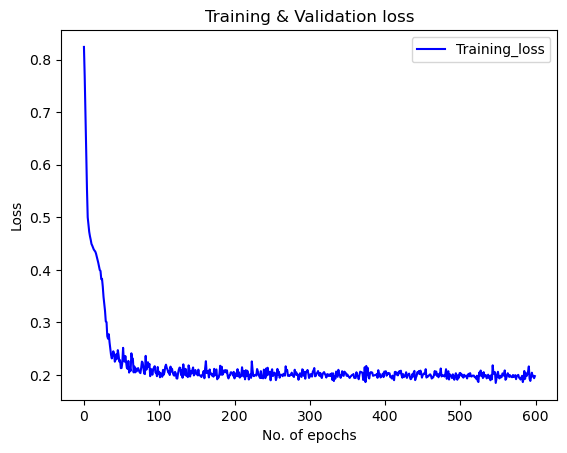

In [193]:
print("Best Loss:",best_loss)
plt_loss_accuracy_fig_2(total_train_loss)

In [194]:
vae = VAE().to(device)
pth_path = 'MNIST_0167_VAE.pth'
state_dict = torch.load(pth_path)
vae.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")
vae.eval()
eval_loss = nn.MSELoss()

Load pth from MNIST_0167_VAE.pth


See the result of recreating.

Loss: [0.21289700269699097, 0.21225523948669434, 0.20029248297214508, 0.20304185152053833]


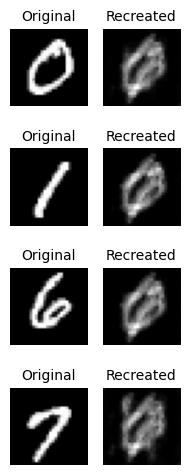

In [195]:
total_output = list()
total_test_loss = list()
for i in range(len(dataset)):
    img, _ = dataset[i]
    img_batch = img.unsqueeze(0)
    output, loss = recreate_img_vae(img_batch, vae, eval_loss)
    total_output.append((img.cpu().detach().numpy().squeeze(0), output.cpu().detach().numpy().squeeze(0)))
    total_test_loss.append(loss.cpu().item())
print("Loss:", total_test_loss)

plt.figure(figsize=(2, 5))
for i, img_idx in enumerate(range(len(dataset))):
    img, output_img = total_output[img_idx]

    # image subplot
    ax_img = plt.subplot(4, 2, 2 * i + 1)
    ax_img.imshow(img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Original", fontsize=10)
    ax_img = plt.subplot(4, 2, 2 * i + 2)
    ax_img.imshow(output_img.squeeze(), cmap='gray')
    ax_img.axis("off")
    ax_img.set_title(f"Recreated", fontsize=10)
plt.tight_layout()
plt.show()


Get the latent space after `reparametrize` which is [1, 128, 1, 1].

In [196]:
VAE_total_latent = dict() # list contains np.array()
for img, y in small_dataloader:
    img = img.to(device)
    mu, logvar = vae.encode(img)
    z = vae.reparametrize(mu, logvar)
    print(z.shape)
    VAE_total_latent[int(y)] = z.cpu().detach().numpy().squeeze()

torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])
torch.Size([1, 1, 1, 1])


### 1-i.
Show the latent codes (encodings) of these four images for both 
models.

In [197]:
print("Autoencoder - Latent Space:")
for i in digits:
    print("Digit", i, ":", AE_total_latent[i])
    print("-------------------------------------")

Autoencoder - Latent Space:
Digit 0 : 10.314316
-------------------------------------
Digit 1 : 676.5658
-------------------------------------
Digit 6 : 34.260727
-------------------------------------
Digit 7 : 106.50004
-------------------------------------


In [198]:
print("VAE - Latent Space:")
for i in digits:
    print("Digit", i, ":", VAE_total_latent[i])
    print("-------------------------------------")

VAE - Latent Space:
Digit 0 : -0.7680401
-------------------------------------
Digit 1 : -2.200117
-------------------------------------
Digit 6 : 0.57931244
-------------------------------------
Digit 7 : -0.68663096
-------------------------------------


### 1-ii.
Generate and compare the decoder outputs by feeding various code 
values into each decoder, and visualize the differences in generation 
behavior between the two models.
* In VAE, latent space is N(0,1), so I use torch.randn to get the input data for decoder.

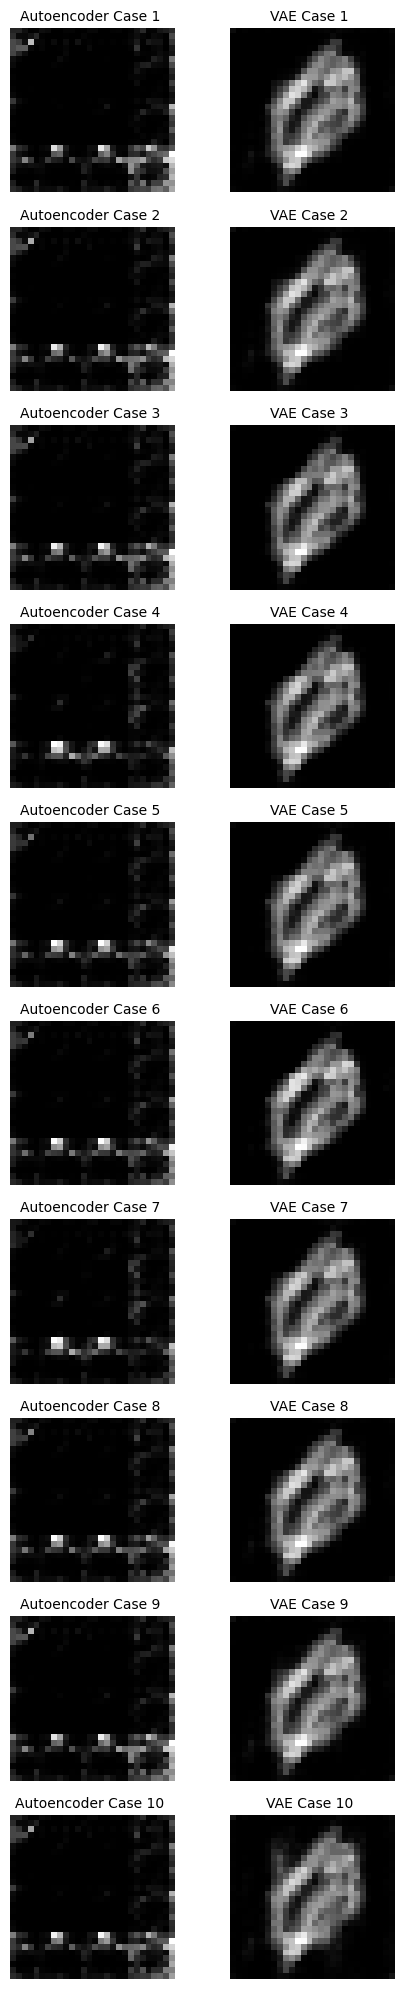

In [199]:
N = 10 # test cases number
# get the decoders
decoder_AE = model_cnn_AE.decoder
decoder_VAE = vae.decoder
# input shape
input_ae = torch.zeros((1, 1, 1, 1))
input_vae = torch.zeros((1, 1, 1, 1))
plt.figure(figsize=(5, 20))
for i in range(N):
    with torch.no_grad():
        x = torch.randn_like(input_ae)
        x = x.to(device)
        out = decoder_AE(x)    
        ax = plt.subplot(10, 2, 2*i+1)
        ax.imshow(out.cpu().squeeze(0,1), cmap='gray')
        ax.axis("off")
        ax.set_title(f"Autoencoder Case {i+1} ", fontsize=10)

        x = torch.randn_like(input_vae)
        x = x.to(device)
        out = decoder_VAE(x)    
        ax = plt.subplot(10, 2, 2*i+2)
        ax.imshow(out.cpu().squeeze(0,1), cmap='gray')
        ax.axis("off")
        ax.set_title(f"VAE Case {i+1} ", fontsize=10)
plt.tight_layout()
plt.show()

### Decoder生成比較
由於VAE中間有隨機取樣(reparameterization 和 KL divergence regularization)的成分在，所以在只有四張訓練圖片下，VAE訓練效果較差，較無法重新建立原始圖片。  
但對於輸入standard normal distribution中的數值給decoder的表現時，**VAE有較好的成果**(可看上圖得知)，可以出現類似物件在圖片中間的效果，生成帶有物件輪廓的影像。  
VAE 的 latent space 經過 regularization，更接近標準常態分布，所以從 N(0,1) 中隨機取 latent code，再透過 decoder，可以產生合理的樣本；而 Autoencoder 的 latent space 沒有限制，隨機取 latent code 無法對應到合理的影像。